# FX Volatility Smile Construction: Reiswich & Wystup (2012) Simplified Parabolic Method
## Applied to EUR/GBP FX Options — Live Market Data (30 January 2026)

**Author:** Albert Galfi  
**Date:** February 2026  
**Valuation Date:** 30 January 2026  

---

### Objective

This notebook implements the **Simplified Parabolic Interpolation** method from:

> Reiswich, D. & Wystup, U. (2012). *"FX Volatility Smile Construction"*, Wilmott Magazine.

The method constructs an arbitrage-consistent implied volatility smile from standard FX option market quotes (ATM straddle, risk reversal, and market strangle / butterfly). I apply it to **EUR/GBP** options data sourced from market data and perform an **out-of-sample validation**: the model is calibrated using **25-delta** data only, then tested against independent **10-delta** quotes.

### Key Features
- Full implementation of the Reiswich & Wystup parabolic formula with FX-specific delta conventions
- Premium-adjusted spot/forward delta handling (required for EUR/GBP where premium is paid in EUR)
- Market strangle pricing and calibration via Brent root-finding (1D problem by construction)
- PCHIP-interpolated EUR ESTR and GBP SONIA discount curves
- Out-of-sample testing: 10-delta risk reversals and smile strangles across the entire term structure
- 3D volatility surface construction

## 1. Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import PchipInterpolator
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Plotting style — dark theme (consistent with VV notebook)
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.facecolor': '#0f172a',
    'figure.facecolor': '#0f172a',
    'axes.edgecolor': '#334155',
    'axes.labelcolor': '#94a3b8',
    'xtick.color': '#64748b',
    'ytick.color': '#64748b',
    'text.color': '#e2e8f0',
    'axes.grid': True,
    'grid.color': '#1e293b',
    'grid.alpha': 0.8,
    'font.size': 11,
    'axes.titlesize': 14,
    'legend.facecolor': '#1e293b',
    'legend.edgecolor': '#334155',
    'legend.fontsize': 10,
})

BLUE   = '#3b82f6'
GOLD   = '#f59e0b'
TEAL   = '#14b8a6'
RED    = '#ef4444'
PURPLE = '#a78bfa'
GREEN  = '#22c55e'

print("Libraries loaded successfully")
print(f"  NumPy {np.__version__}, Pandas {pd.__version__}")

import os
os.makedirs('../../outputs/reiswich_wystup', exist_ok=True)

Libraries loaded successfully
  NumPy 2.0.2, Pandas 2.3.3


---
## 2. Theoretical Background: The Reiswich & Wystup Method

### 2.1 The FX Smile Construction Problem

Unlike equity markets where strike-volatility pairs are directly observable, the FX OTC derivative market parametrises the smile through three market-quoted instruments for each tenor and delta level:

| Instrument | Symbol | Market Meaning |
|:-----------|:-------|:---------------|
| **ATM Straddle** | $\sigma_{ATM}$ | Delta-neutral straddle volatility (level of the smile) |
| **Risk Reversal** | $\sigma_{\Delta\text{-RR}}$ | $\sigma_{\Delta C} - \sigma_{\Delta P}$ measures **skewness** |
| **Market Butterfly** | $\sigma_{\Delta\text{-S-Q}}$ | Quoted/broker strangle margin loosely measures **convexity** |

A smile construction procedure must recover a complete volatility function $\sigma(K)$ from these three constraints.

### 2.2 Market Strangle vs. Smile Strangle

This is the **most common source of error** in FX smile construction (Reiswich & Wystup, 2012). The market quotes a **broker strangle** $\sigma_{\Delta\text{-S-Q}}$, which is *not* the same as the smile strangle $\sigma_S$.

**Market strangle volatility** (Eq. 4):

$$\sigma_{\Delta\text{-S-M}} = \sigma_{ATM} + \sigma_{\Delta\text{-S-Q}}$$

This single volatility determines two strikes (call and put at the quoting delta) and a strangle price:

$$v_{\Delta\text{-S-M}} = v(K_{\Delta C\text{-S-M}},\ \sigma_{\Delta\text{-S-M}},\ +1) + v(K_{\Delta P\text{-S-M}},\ \sigma_{\Delta\text{-S-M}},\ -1) \tag{8}$$

The calibrated smile $\bar{\sigma}(K)$ must recover this price exactly (Eq. 9), even though the smile-consistent volatilities at these strikes will generally differ from $\sigma_{\Delta\text{-S-M}}$.

The **smile strangle** is defined post-calibration (Eq. 20):

$$\sigma_S = \frac{\bar{\sigma}(K_{\Delta C}) + \bar{\sigma}(K_{\Delta P})}{2} - \sigma_{ATM}$$

The simplified Malz (1997) formula that uses $\sigma_{\Delta\text{-S-Q}}$ directly only works when $|\sigma_{RR}| < 1\%$. For skewed smiles, it produces a non-market-consistent setup.

### 2.3 The Simplified Parabolic Formula (Theorem 1)

Reiswich & Wystup propose fitting a **parabola in delta space** (Eq. 24):

$$\sigma(\Delta,\ \sigma_S) = \sigma_{ATM} + c_1(\Delta - \Delta_{ATM}) + c_2(\Delta - \Delta_{ATM})^2$$

where $\Delta$ is a **call delta** (for any convention). The coefficients (Eq. 25):

$$c_1 = \frac{a^2(2\sigma_S + \sigma_R) - 2a(2\sigma_S + \sigma_R)(\tilde{\Delta} + \Delta_{ATM}) + 2(\tilde{\Delta}^2 \sigma_R + 4\sigma_S \tilde{\Delta} \Delta_{ATM} + \sigma_R \Delta_{ATM}^2)}{2(2\tilde{\Delta} - a)(\tilde{\Delta} - \Delta_{ATM})(\tilde{\Delta} - a + \Delta_{ATM})}$$

$$c_2 = \frac{4\tilde{\Delta}\sigma_S - a(2\sigma_S + \sigma_R) + 2\sigma_R \Delta_{ATM}}{2(2\tilde{\Delta} - a)(\tilde{\Delta} - \Delta_{ATM})(\tilde{\Delta} - a + \Delta_{ATM})}$$

**Key properties:**
- **ATM vol matched by construction:** $\sigma(\Delta_{ATM}) = \sigma_{ATM}$
- **Risk reversal matched by construction:** $\sigma(\tilde{\Delta}_C) - \sigma(a + \tilde{\Delta}_P) = \sigma_R$
- **Only the market strangle requires calibration** a 1D root search for $\sigma_S$

### 2.4 The Parameter $a$ (Put-Call Delta Parity)

| Delta Type | $a$ | Note |
|:-----------|:----|:-----|
| Spot | $e^{-r_f \tau}$ | Foreign discount factor |
| Forward | $1$ | Trivial |
| Premium-adjusted spot | $e^{-r_f \tau} \cdot K_{\tilde{\Delta}P} / f$ | Depends on put strike (circular, resolved iteratively) |
| Premium-adjusted forward | $K_{\tilde{\Delta}P} / f$ | Depends on put strike |

For premium-adjusted deltas, the put volatility at each calibration step is $\sigma_{\tilde{\Delta}P} = \sigma_{ATM} - \frac{1}{2}\sigma_R + \sigma_S$, which determines the put strike and hence $a$.

### 2.5 Delta to Strike Conversion (Theorem 2)

The transformation $K \mapsto \sigma(K)$ is obtained by solving the implicit equation (Eq. 27):

$$\sigma = \sigma_{ATM} + c_1(\Delta(K, \sigma, +1) - \Delta_{ATM}) + c_2(\Delta(K, \sigma, +1) - \Delta_{ATM})^2$$

Reiswich & Wystup prove this function exists and is **differentiable** (useful for local vol and arbitrage tests).

### 2.6 Calibration as a Root Search

The calibration reduces to finding $\sigma_S$ such that (Eq. 26):

$$f(\sigma_S) = v(K_{\tilde{\Delta}C\text{-S-M}},\ \sigma(K_{\tilde{\Delta}C\text{-S-M}},\ \sigma_S),\ +1) + v(K_{\tilde{\Delta}P\text{-S-M}},\ \sigma(K_{\tilde{\Delta}P\text{-S-M}},\ \sigma_S),\ -1) - v_{\tilde{\Delta}\text{-S-M}} = 0$$

Starting from $\sigma_S^{(0)} = \sigma_{\Delta\text{-S-Q}}$, Brent's method converges to the smile strangle that exactly reproduces the market strangle price.

---
## 3. Load & Parse Market Data

### About the Data

The dataset contains mid rates for EUR/GBP FX options sourced from market data as of **30 January 2026**.

### EUR/GBP Quoting Conventions

| Convention | Detail |
|:-----------|:-------|
| **Pair** | EUR/GBP = price of 1 EUR in GBP |
| **Base/Foreign** | EUR is the foreign (base) currency |
| **Quote/Domestic** | GBP is the domestic (quote) currency |
| **ATM Style** | Delta-Neutral Straddle (DNS) for all tenors |
| **Delta type** | Premium-adjusted spot delta (tenors up to 1Y), premium-adjusted forward delta (> 1Y) |
| **Premium currency** | EUR (the foreign currency) hence premium adjustment is required |

In [2]:
# ─── Load FX Data ───
df_raw = pd.read_excel('../../data/FX data.xlsx', sheet_name='Sheet3')

print(f"Loaded {len(df_raw)} rows from FX data")
print(f"Valuation date: {df_raw['VALUATION_DATE'].iloc[0]}")
print(f"Currency pair: {df_raw['PRODUCT_UNDERLYING'].dropna().iloc[0]}")
print(f"\nInstrument types present:")
print(df_raw['OPTIONTYPE'].value_counts().to_string())

Loaded 181 rows from FX data
Valuation date: 20260130
Currency pair: EURGBP

Instrument types present:
OPTIONTYPE
RiskReversal            47
SmileStrangleMargin     47
MarketStrangleMargin    38
ForwardPoints           24
StraddleVol             19
Volatility               5
SpotRate                 1


### 3.1 Spot Rate & Forward Points

In [3]:
# ─── Extract Spot Rate & Forward Points ───
spot = float(df_raw[df_raw['PRODUCT_TYPE'] == 'FXSpot']['MID'].values[0])
S0 = spot  # alias used in ReisWichWystup class
print(f"EUR/GBP Spot Rate: {spot:.8f}")
print(f"Interpretation: 1 EUR = {spot:.6f} GBP")

# Forward points
fwd_df = df_raw[df_raw['PRODUCT_TYPE'] == 'FXForward'].copy()
fwd_df['TERM_M'] = fwd_df['TERM'].astype(float)
fwd_df['FWD_PTS'] = fwd_df['MID'].astype(float)
fwd_df = fwd_df.sort_values('TERM_M').reset_index(drop=True)

# Also keep as fwd_data for build_market_data compatibility
fwd_data = fwd_df.copy()

valuation_date = datetime(2026, 1, 30)

print(f"\nEUR/GBP Forward Rates:")
print(f"{'Tenor':>6s}  {'Fwd Points':>12s}  {'Outright Fwd':>14s}  {'Term (M)':>10s}")
print("-" * 50)
for _, row in fwd_df.iterrows():
    fwd_rate = spot + row['FWD_PTS']
    print(f"{str(row['PRODUCT_TENOR']):>6s}  {row['FWD_PTS']:+12.6f}  {fwd_rate:14.6f}  {row['TERM_M']:10.2f}")

EUR/GBP Spot Rate: 0.86643258
Interpretation: 1 EUR = 0.866433 GBP

EUR/GBP Forward Rates:
 Tenor    Fwd Points    Outright Fwd    Term (M)
--------------------------------------------------
    ON     +0.000042        0.866474        0.05
    1W     +0.000294        0.866726        0.25
    2W     +0.000586        0.867018        0.50
    3W     +0.000877        0.867309        0.75
    1M     +0.001172        0.867605        1.00
    2M     +0.002648        0.869081        2.00
    3M     +0.003817        0.870250        3.00
    4M     +0.004959        0.871392        4.00
    5M     +0.006138        0.872571        5.00
    6M     +0.007342        0.873774        6.00
    9M     +0.010779        0.877211        9.00
    1Y     +0.014241        0.880674       12.00
   18M     +0.020818        0.887251       18.00
    2Y     +0.027652        0.894085       24.00
    3Y     +0.041217        0.907649       36.00
    4Y     +0.054301        0.920734       48.00
    5Y     +0.067228     

---
## 4. Discount Curves: EUR ESTR & GBP SONIA

For Garman-Kohlhagen pricing we need:

- **$r_d$** GBP SONIA (domestic/quote)
- **$r_f$** EUR ESTR (foreign/base)

$$F(T) = S_0 \cdot \frac{\text{DF}_{\text{EUR}}(T)}{\text{DF}_{\text{GBP}}(T)} = S_0 \cdot e^{(r_d - r_f) \cdot T}$$

In [4]:
# Load Discount Curves
eur_raw = pd.read_excel('../../data/discount_curves.xlsx', sheet_name='EUR_ESTR')
gbp_raw = pd.read_excel('../../data/discount_curves.xlsx', sheet_name='GBP_SONIA')

val_date = datetime(2026, 1, 30)

def build_df_curve(df, name):
    rows = []
    for _, r in df.iterrows():
        dt = pd.to_datetime(r['date'])
        T_years = (dt - val_date).days / 365
        rows.append({
            'tenor':     r['tenor'],
            'date':      dt,
            'T':         T_years,
            'zero_rate': r['zero_rate_pct'] / 100,
            'df':        r['discount_factor']
        })
    result = pd.DataFrame(rows).sort_values('T').reset_index(drop=True)
    print(f"\n{name}: {len(result)} nodes, T range [{result['T'].min():.4f}, {result['T'].max():.2f}]")
    return result

eur_curve = build_df_curve(eur_raw, "EUR ESTR curve")
gbp_curve = build_df_curve(gbp_raw, "GBP SONIA curve")

# PCHIP monotone cubic interpolation on log discount factors
eur_interp = PchipInterpolator(eur_curve['T'], np.log(eur_curve['df']))
gbp_interp = PchipInterpolator(gbp_curve['T'], np.log(gbp_curve['df']))

def df_eur(T):
    return np.exp(eur_interp(T))

def df_gbp(T):
    return np.exp(gbp_interp(T))

def forward_rate(T):
    return spot * df_eur(T) / df_gbp(T)

def r_dom(T):
    if T <= 0: return gbp_curve['zero_rate'].iloc[0]
    return -np.log(df_gbp(T)) / T

def r_for(T):
    if T <= 0: return eur_curve['zero_rate'].iloc[0]
    return -np.log(df_eur(T)) / T

# Forward Rate Validation
print("\n─── Forward Rate Validation ───")
print(f"{'Tenor':>6s}  {'Market Fwd':>12s}  {'Model Fwd':>12s}  {'Basis (pips)':>12s}")
for _, r in fwd_df.iterrows():
    T_yrs = r['TERM_M'] / 12
    model_fwd = forward_rate(T_yrs)
    mkt_fwd = spot + r['FWD_PTS']
    diff_pips = (model_fwd - mkt_fwd) * 10000
    print(f"{str(r['PRODUCT_TENOR']):>6s}  {mkt_fwd:12.6f}  {model_fwd:12.6f}  {diff_pips:+12.2f}")


EUR ESTR curve: 34 nodes, T range [0.0000, 30.03]

GBP SONIA curve: 32 nodes, T range [0.0000, 30.02]

─── Forward Rate Validation ───
 Tenor    Market Fwd     Model Fwd  Basis (pips)
    ON      0.866474      0.866497         +0.22
    1W      0.866726      0.866752         +0.26
    2W      0.867018      0.867071         +0.53
    3W      0.867309      0.867390         +0.81
    1M      0.867605      0.867709         +1.04
    2M      0.869081      0.868973         -1.08
    3M      0.870250      0.870225         -0.25
    4M      0.871392      0.871387         -0.05
    5M      0.872571      0.872546         -0.25
    6M      0.873774      0.873687         -0.87
    9M      0.877211      0.876960         -2.51
    1Y      0.880674      0.880161         -5.13
   18M      0.887251      0.886543         -7.08
    2Y      0.894085      0.893002        -10.83
    3Y      0.907649      0.905806        -18.43
    4Y      0.920734      0.918373        -23.61
    5Y      0.933660      0.931

### 4.1 Discount Curve Visualisation

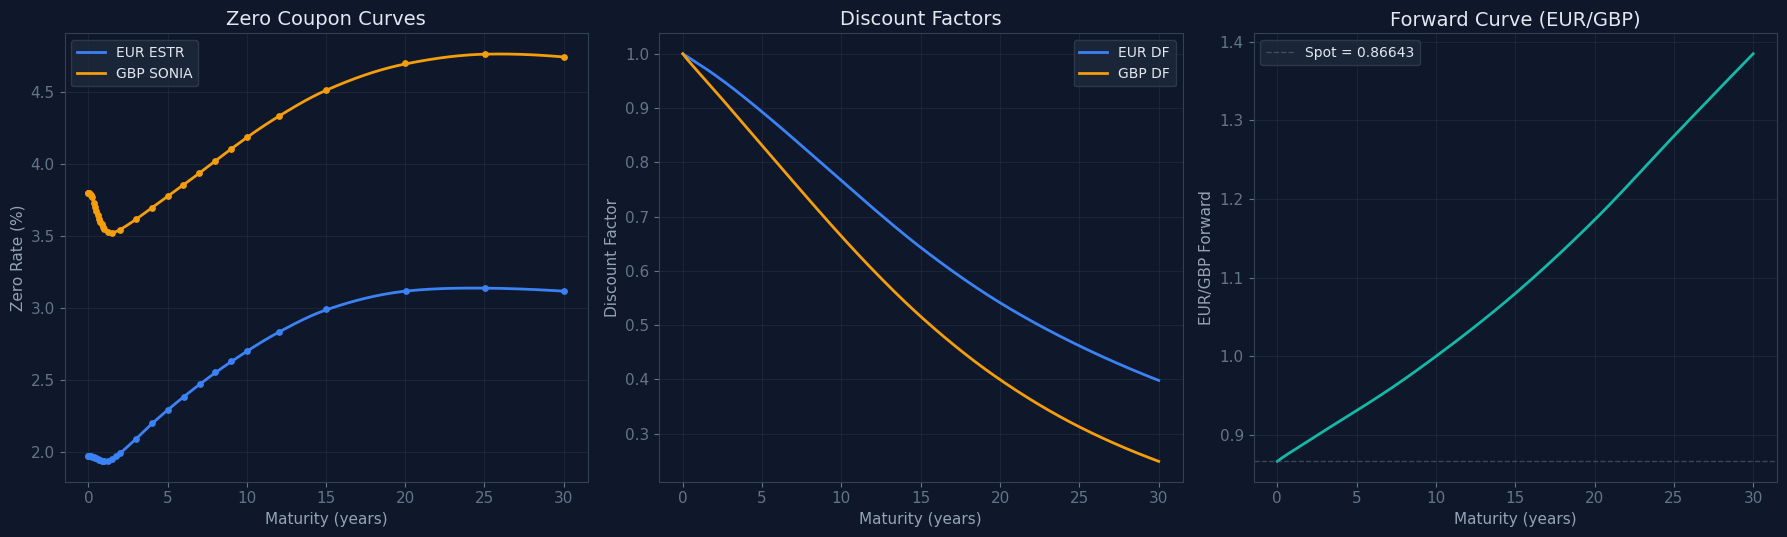

GBP rates > EUR rates -> forward points positive (EUR/GBP forward > spot)


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

T_plot = np.linspace(0.01, 30, 500)
eur_zr = [(np.exp(-np.log(df_eur(t))/t) - 1) * 100 for t in T_plot]
gbp_zr = [(np.exp(-np.log(df_gbp(t))/t) - 1) * 100 for t in T_plot]

axes[0].plot(T_plot, eur_zr, color=BLUE, lw=2, label='EUR ESTR')
axes[0].plot(T_plot, gbp_zr, color=GOLD, lw=2, label='GBP SONIA')
axes[0].scatter(eur_curve['T'], eur_curve['zero_rate']*100, color=BLUE, s=15, zorder=5)
axes[0].scatter(gbp_curve['T'], gbp_curve['zero_rate']*100, color=GOLD, s=15, zorder=5)
axes[0].set_xlabel('Maturity (years)')
axes[0].set_ylabel('Zero Rate (%)')
axes[0].set_title('Zero Coupon Curves')
axes[0].legend()

axes[1].plot(T_plot, [df_eur(t) for t in T_plot], color=BLUE, lw=2, label='EUR DF')
axes[1].plot(T_plot, [df_gbp(t) for t in T_plot], color=GOLD, lw=2, label='GBP DF')
axes[1].set_xlabel('Maturity (years)')
axes[1].set_ylabel('Discount Factor')
axes[1].set_title('Discount Factors')
axes[1].legend()

fwd_plot = [forward_rate(t) for t in T_plot]
axes[2].plot(T_plot, fwd_plot, color=TEAL, lw=2)
axes[2].axhline(S0, color='#64748b', ls='--', lw=1, alpha=0.5, label=f'Spot = {S0:.5f}')
axes[2].set_xlabel('Maturity (years)')
axes[2].set_ylabel('EUR/GBP Forward')
axes[2].set_title('Forward Curve (EUR/GBP)')
axes[2].legend()

plt.tight_layout()
plt.savefig('../../outputs/reiswich_wystup/rw_discount_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("GBP rates > EUR rates -> forward points positive (EUR/GBP forward > spot)")

---
## 5. Volatility Market Data

FX options on EUR/GBP are quoted using three instruments for each delta level:

| Instrument | Symbol | Meaning |
|:-----------|:-------|:--------|
| **ATM Straddle** | $\sigma_{ATM}$ | Delta-neutral straddle vol |
| **Risk Reversal** | $\sigma_{\Delta\text{-RR}}$ | $\sigma_{\Delta C} - \sigma_{\Delta P}$ (skewness) |
| **Market Butterfly** | $\sigma_{\Delta\text{-S-Q}}$ | Broker/quoted strangle margin (convexity) |
| **Smile Strangle** | $\sigma_{\Delta\text{-S-S}}$ | Calibration output for validation |

**Sign convention:** RR is quoted as *EUR call vol minus EUR put vol*.

In [6]:
# ─── Parse and organise data by instrument type ───

# Extract spot rate
spot = float(df_raw[df_raw['OPTIONTYPE'] == 'SpotRate']['MID'].iloc[0])
print(f"EUR/GBP Spot: {spot:.8f}")

# ATM vols (StraddleVol + ATMF Volatility)
atm_df = df_raw[df_raw['OPTIONTYPE'].isin(['StraddleVol', 'Volatility'])].copy()
atm_df['TERM_M'] = atm_df['TERM'].astype(float)
atm_df['VOL'] = atm_df['MID'].astype(float) / 100  # Convert to decimal
atm_df = atm_df.sort_values('TERM_M').reset_index(drop=True)

# 25Δ and 10Δ Risk Reversals (RR)
rr_df = df_raw[df_raw['OPTIONTYPE'] == 'RiskReversal'].copy()
rr_df['TERM_M'] = rr_df['TERM'].astype(float)
rr_df['DELTA_N'] = pd.to_numeric(rr_df['DELTA'], errors='coerce')
rr_df['VOL'] = rr_df['MID'].astype(float) / 100

rr25_df = rr_df[rr_df['DELTA_N'] == 25].sort_values('TERM_M').reset_index(drop=True)
rr10_df = rr_df[rr_df['DELTA_N'] == 10].sort_values('TERM_M').reset_index(drop=True)

# 25Δ and 10Δ MFly (Market Strangle Margin - Required for R&W Calibration)
fly_df = df_raw[df_raw['OPTIONTYPE'] == 'MarketStrangleMargin'].copy()
fly_df['TERM_M'] = fly_df['TERM'].astype(float)
fly_df['DELTA_N'] = pd.to_numeric(fly_df['DELTA'], errors='coerce')
fly_df['VOL'] = fly_df['MID'].astype(float) / 100

fly25_df = fly_df[fly_df['DELTA_N'] == 25].sort_values('TERM_M').reset_index(drop=True)
fly10_df = fly_df[fly_df['DELTA_N'] == 10].sort_values('TERM_M').reset_index(drop=True)

# 25Δ and 10Δ SSM (Smile Strangle Margin - Used for out-of-sample validation)
ssm_df = df_raw[df_raw['OPTIONTYPE'] == 'SmileStrangleMargin'].copy()
ssm_df['TERM_M'] = ssm_df['TERM'].astype(float)
ssm_df['DELTA_N'] = pd.to_numeric(ssm_df['DELTA'], errors='coerce')
ssm_df['VOL'] = ssm_df['MID'].astype(float) / 100

ssm25_df = ssm_df[ssm_df['DELTA_N'] == 25].sort_values('TERM_M').reset_index(drop=True)
ssm10_df = ssm_df[ssm_df['DELTA_N'] == 10].sort_values('TERM_M').reset_index(drop=True)

print(f"\n─── Data Summary ───")
print(f"  ATM vols:     {len(atm_df):2d} tenors")
print(f"  25Δ RR:       {len(rr25_df):2d} tenors")
print(f"  25Δ MFly:     {len(fly25_df):2d} tenors")
print(f"  25Δ SSM:      {len(ssm25_df):2d} tenors")

EUR/GBP Spot: 0.86643258

─── Data Summary ───
  ATM vols:     24 tenors
  25Δ RR:       24 tenors
  25Δ MFly:     19 tenors
  25Δ SSM:      24 tenors


In [7]:
# ─── Build unified tenor grid ───

# Create lookup dictionaries keyed by TERM_M (months)
atm_dict = {float(r['TERM_M']): r for _, r in atm_df.iterrows()}
rr25_dict = {float(r['TERM_M']): r for _, r in rr25_df.iterrows()}
fly25_dict = {float(r['TERM_M']): r for _, r in fly25_df.iterrows()}
ssm25_dict = {float(r['TERM_M']): r for _, r in ssm25_df.iterrows()}

rr10_dict = {float(r['TERM_M']): r for _, r in rr10_df.iterrows()}
ssm10_dict = {float(r['TERM_M']): r for _, r in ssm10_df.iterrows()}

# Find common tenors for 25Δ calibration 
# R&W requires ATM, Risk Reversal, and MARKET STRANGLE MARGIN (fly)
common_25d = sorted(set(atm_dict.keys()) & set(rr25_dict.keys()) & set(fly25_dict.keys()))
print(f"Tenors with complete 25Δ data: {len(common_25d)}")

# Build calibration table
calib_data = []
print(f"\n{'Tenor':>6s} | {'T(yr)':>6s} | {'σ_ATM':>7s} | {'RR25':>7s} | {'FLY25':>7s} | {'SSM25':>7s} | {'Delta Conv':>10s} | {'ATM Conv':>13s}")
print("─" * 90)

for tm in common_25d:
    atm_row = atm_dict[tm]
    rr_row = rr25_dict[tm]
    fly_row = fly25_dict[tm]
    
    sigma_atm = float(atm_row['VOL'])
    rr25 = float(rr_row['VOL'])
    fly25 = float(fly_row['VOL'])
    
    # Fetch SSM25 purely for display/logging (R&W actual calibration strictly uses fly25)
    ssm25 = float(ssm25_dict[tm]['VOL']) if tm in ssm25_dict else None
    
    T_years = tm / 12.0
    delta_conv = str(rr_row['DELTACONVENTION'])
    atm_conv = str(atm_row['INSTRUMENTCONVENTION'])
    tenor_label = str(atm_row['PRODUCT_TENOR'])
    
    # Grab 10Δ data if available (for out-of-sample validation)
    rr10_val = float(rr10_dict[tm]['VOL']) if tm in rr10_dict else None
    ssm10_val = float(ssm10_dict[tm]['VOL']) if tm in ssm10_dict else None
    
    have_10d = (rr10_val is not None) and (ssm10_val is not None)
    
    # Calculate 10-delta outright wings using SSM for accurate validation comparison
    sigma_10p = sigma_atm + ssm10_val - (rr10_val / 2.0) if have_10d else None
    sigma_10c = sigma_atm + ssm10_val + (rr10_val / 2.0) if have_10d else None
    
    calib_data.append({
        'tenor': tenor_label, 'T': T_years, 'term_m': tm,
        'sigma_atm': sigma_atm, 'rr25': rr25, 'fly25': fly25, 'ssm25': ssm25,
        'delta_conv': delta_conv,
        'atm_conv': atm_conv,
        'sigma_10p': sigma_10p, 'sigma_10c': sigma_10c,
        'rr10': rr10_val, 'ssm10': ssm10_val,
    })
    
    ssm_str = f"{ssm25*100:6.3f}%" if ssm25 is not None else "   N/A "
    print(f"{tenor_label:>6s} | {T_years:6.3f} | {sigma_atm*100:6.3f}% | {rr25*100:+6.3f}% | {fly25*100:6.3f}% | {ssm_str:>7s} | {delta_conv:>10s} | {atm_conv:>13s}")

calib_df = pd.DataFrame(calib_data)
print("─" * 90)
print(f"✓ {len(calib_df)} tenors ready for R&W calibration (using Market Strangle / FLY25)")
print(f"✓ {calib_df['sigma_10p'].notna().sum()} tenors also have 10Δ SSM data for out-of-sample validation")

Tenors with complete 25Δ data: 19

 Tenor |  T(yr) |   σ_ATM |    RR25 |   FLY25 |   SSM25 | Delta Conv |      ATM Conv
──────────────────────────────────────────────────────────────────────────────────────────
    ON |  0.004 |  2.619% | +0.207% |  0.075% |  0.082% |       Spot | Delta Neutral
    1W |  0.021 |  4.478% | +0.343% |  0.118% |  0.122% |       Spot | Delta Neutral
    2W |  0.042 |  4.164% | +0.364% |  0.117% |  0.121% |       Spot | Delta Neutral
    3W |  0.062 |  4.125% | +0.377% |  0.118% |  0.123% |       Spot | Delta Neutral
    1M |  0.083 |  4.094% | +0.390% |  0.120% |  0.125% |       Spot | Delta Neutral
    2M |  0.167 |  4.294% | +0.470% |  0.136% |  0.143% |       Spot | Delta Neutral
    3M |  0.250 |  4.434% | +0.537% |  0.150% |  0.158% |       Spot | Delta Neutral
    4M |  0.333 |  4.612% | +0.590% |  0.163% |  0.171% |       Spot | Delta Neutral
    5M |  0.417 |  4.757% | +0.637% |  0.175% |  0.184% |       Spot | Delta Neutral
    6M |  0.500 |  4.872

### 5.1 Volatility Term Structure

NameError: name 'atmf' is not defined

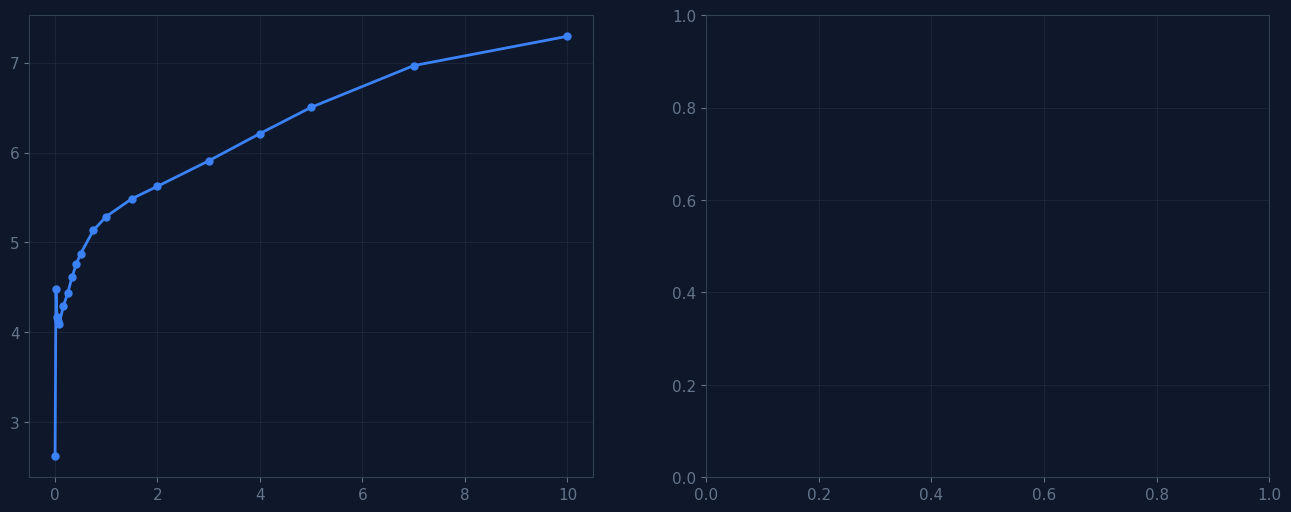

In [8]:
import matplotlib.pyplot as plt

# Define your colors (assuming you had these defined earlier in the notebook)
BLUE, RED, GOLD, TEAL = '#3b82f6', '#ef4444', '#eab308', '#14b8a6'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: ATM Volatility Term Structure ---
# We multiply by 100 because calib_df stored absolute decimals
axes[0].plot(calib_df['T'], calib_df['sigma_atm'] * 100, 'o-', color=BLUE, lw=2, markersize=5, label='ATM (DNS)')

# Optional: keep ATMF from raw data if you still want to visualize the basis
if len(atmf) > 0:
    atmf_s = atmf.sort_values('TERM')
    axes[0].plot(atmf_s['TERM']/12.0, atmf_s['MID'], 's--', color=TEAL, lw=1.5, markersize=4, alpha=0.8, label='ATMF Vol')

axes[0].set_xlabel('Maturity (years)')
axes[0].set_ylabel('Implied Vol (%)')
axes[0].set_title('ATM Volatility Term Structure')
axes[0].grid(True, alpha=0.2)
axes[0].legend()


# --- Plot 2: Skew & Convexity Term Structure ---
axes[1].plot(calib_df['T'], calib_df['rr25'] * 100, 'o-', color=RED, lw=2, markersize=5, label='25D RR')

# Only plot 10D RR where valid non-null data exists in our unified grid
valid_10d = calib_df.dropna(subset=['rr10'])
if len(valid_10d) > 0:
    axes[1].plot(valid_10d['T'], valid_10d['rr10'] * 100, 's--', color=RED, lw=1.5, markersize=4, alpha=0.6, label='10D RR')

axes[1].plot(calib_df['T'], calib_df['fly25'] * 100, 'o-', color=GOLD, lw=2, markersize=5, label='25D Mkt BF')

# Zero line for visual reference of Skew inversion
axes[1].axhline(0, color='#64748b', ls='--', lw=0.5, alpha=0.5)

axes[1].set_xlabel('Maturity (years)')
axes[1].set_ylabel('Vol (%)')
axes[1].set_title('Skew & Convexity Term Structure')
axes[1].grid(True, alpha=0.2)
axes[1].legend()

plt.tight_layout()
plt.savefig('../../outputs/reiswich_wystup/rw_vol_term_structure.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Black-Scholes Building Blocks

### 6.1 Option Pricing (Garman-Kohlhagen)

$$v(K, \sigma, \phi) = \phi \, e^{-r_d \tau} \left[ f \, N(\phi \, d_+) - K \, N(\phi \, d_-) \right]$$

where $d_{\pm} = \frac{\ln(f/K) \pm \frac{1}{2}\sigma^2\tau}{\sigma\sqrt{\tau}}$ and $\phi = +1$ for call, $-1$ for put.

### 6.2 Delta Conventions (Table 2 in Reiswich & Wystup)

| Delta Type | Formula | Used for |
|:-----------|:--------|:---------|
| Spot $\Delta_S$ | $\phi e^{-r_f\tau} N(\phi d_+)$ | G7 pairs, short tenors |
| Forward $\Delta_f$ | $\phi N(\phi d_+)$ | G7 pairs, long tenors |
| Premium-adj. spot $\Delta_{S,pa}$ | $\phi e^{-r_f\tau} \frac{K}{f} N(\phi d_-)$ | **EUR/GBP up to 1Y** |
| Premium-adj. forward $\Delta_{f,pa}$ | $\phi \frac{K}{f} N(\phi d_-)$ | **EUR/GBP > 1Y** |

In [9]:
def bs_price(f, K, sigma, tau, rd, phi):
    """
    Black-Scholes FX option price.
    
    Parameters
    ----------
    f     : Forward rate
    K     : Strike
    sigma : Implied volatility (as decimal, e.g. 0.05 for 5%)
    tau   : Time to maturity in years
    rd    : Domestic risk-free rate (continuously compounded)
    phi   : +1 for call, -1 for put
    
    Returns
    -------
    Option price in domestic currency units (per 1 unit of foreign notional)
    """
    if sigma <= 0 or tau <= 0:
        return max(phi * (f - K), 0) * np.exp(-rd * tau)
    
    sqrt_tau = np.sqrt(tau)
    d_plus = (np.log(f / K) + 0.5 * sigma**2 * tau) / (sigma * sqrt_tau)
    d_minus = d_plus - sigma * sqrt_tau
    
    price = phi * np.exp(-rd * tau) * (f * norm.cdf(phi * d_plus) - K * norm.cdf(phi * d_minus))
    return price

# Quick test with paper's EUR-USD example (Table 3)
f_test = 1.3070
K_test = 1.3096
sigma_test = 0.216215
tau_test = 0.0849
rd_test = 0.003525

call_price = bs_price(f_test, K_test, sigma_test, tau_test, rd_test, 1)
put_price = bs_price(f_test, K_test, sigma_test, tau_test, rd_test, -1)
print(f"Test: EUR-USD ATM straddle value = {call_price + put_price:.6f}")

Test: EUR-USD ATM straddle value = 0.065766


In [10]:
def d_plus_minus(f, K, sigma, tau):
    """Compute d+ and d- for Black-Scholes."""
    sqrt_tau = np.sqrt(tau)
    d_plus = (np.log(f / K) + 0.5 * sigma**2 * tau) / (sigma * sqrt_tau)
    d_minus = d_plus - sigma * sqrt_tau
    return d_plus, d_minus

def delta_spot(f, K, sigma, tau, rf, phi):
    """Standard (unadjusted) spot delta: Δ_S = φ·e^{-r_f·τ}·N(φ·d+)"""
    d_plus, _ = d_plus_minus(f, K, sigma, tau)
    return phi * np.exp(-rf * tau) * norm.cdf(phi * d_plus)

def delta_forward(f, K, sigma, tau, phi):
    """Standard forward delta: Δ_f = φ·N(φ·d+)"""
    d_plus, _ = d_plus_minus(f, K, sigma, tau)
    return phi * norm.cdf(phi * d_plus)

def delta_spot_pa(f, K, sigma, tau, rf, phi):
    """Premium-adjusted spot delta: Δ_{S,pa} = φ·e^{-r_f·τ}·(K/f)·N(φ·d-)"""
    _, d_minus = d_plus_minus(f, K, sigma, tau)
    return phi * np.exp(-rf * tau) * (K / f) * norm.cdf(phi * d_minus)

def delta_forward_pa(f, K, sigma, tau, phi):
    """Premium-adjusted forward delta: Δ_{f,pa} = φ·(K/f)·N(φ·d-)"""
    _, d_minus = d_plus_minus(f, K, sigma, tau)
    return phi * (K / f) * norm.cdf(phi * d_minus)

# Unified interface
def delta_func(f, K, sigma, tau, rd, rf, phi, delta_type='spot_pa'):
    """
    Compute delta for the given convention.
    delta_type: 'spot', 'forward', 'spot_pa', 'forward_pa'
    """
    if delta_type == 'spot':
        return delta_spot(f, K, sigma, tau, rf, phi)
    elif delta_type == 'forward':
        return delta_forward(f, K, sigma, tau, phi)
    elif delta_type == 'spot_pa':
        return delta_spot_pa(f, K, sigma, tau, rf, phi)
    elif delta_type == 'forward_pa':
        return delta_forward_pa(f, K, sigma, tau, phi)
    else:
        raise ValueError(f"Unknown delta type: {delta_type}")

print("Delta functions defined successfully.")
print()

# Verify: for a spot delta, the put-call parity should hold
K_ex = 1.30
f_ex = 1.3070
sigma_ex = 0.22
tau_ex = 0.0849
rf_ex = 0.020113

d_call = delta_spot(f_ex, K_ex, sigma_ex, tau_ex, rf_ex, +1)
d_put = delta_spot(f_ex, K_ex, sigma_ex, tau_ex, rf_ex, -1)
print(f"Spot delta parity check: Δ_call - Δ_put = {d_call - d_put:.6f}")
print(f"Expected: e^(-rf*τ) = {np.exp(-rf_ex * tau_ex):.6f}")

Delta functions defined successfully.

Spot delta parity check: Δ_call - Δ_put = 0.998294
Expected: e^(-rf*τ) = 0.998294


### 6.3 ATM Delta-Neutral Strike & Strike from Delta Inversion

For **premium-adjusted** deltas: $K_{ATM} = f \cdot e^{-\frac{1}{2}\sigma_{ATM}^2 \tau}$

For **unadjusted** deltas: $K_{ATM} = f \cdot e^{+\frac{1}{2}\sigma_{ATM}^2 \tau}$

Strike inversion for premium-adjusted deltas requires Brent's root search since the call delta is non-monotone in strike.

In [11]:
def atm_strike_dn(f, sigma_atm, tau, delta_type='spot_pa'):
    """
    Compute the ATM delta-neutral strike.
    
    For premium-adjusted deltas: K_ATM = f * exp(-0.5 * σ² * τ)
    For standard deltas:         K_ATM = f * exp(+0.5 * σ² * τ)
    """
    if delta_type in ('spot_pa', 'forward_pa'):
        return f * np.exp(-0.5 * sigma_atm**2 * tau)
    else:
        return f * np.exp(+0.5 * sigma_atm**2 * tau)

# Test
f_test = 1.3070
sigma_test = 0.216215
tau_test = 0.0849

K_atm_pa = atm_strike_dn(f_test, sigma_test, tau_test, 'spot_pa')
K_atm_std = atm_strike_dn(f_test, sigma_test, tau_test, 'spot')
print(f"Premium-adjusted DN strike: {K_atm_pa:.4f}")
print(f"Standard DN strike:         {K_atm_std:.4f}")
print(f"Paper's EUR-USD K_ATM:      1.3096  (using standard spot delta)")

Premium-adjusted DN strike: 1.3044
Standard DN strike:         1.3096
Paper's EUR-USD K_ATM:      1.3096  (using standard spot delta)


In [12]:
def strike_from_delta_analytic(f, target_delta, sigma, tau, rf, phi, delta_type='spot'):
    """
    Analytically compute strike from unadjusted delta.
    Only works for 'spot' and 'forward' (non-premium-adjusted) deltas.
    """
    sqrt_tau = np.sqrt(tau)
    if delta_type == 'spot':
        x = norm.ppf(phi * np.exp(rf * tau) * target_delta)
    elif delta_type == 'forward':
        x = norm.ppf(phi * target_delta)
    else:
        raise ValueError("Analytic inversion only for non-premium-adjusted deltas")
    
    K = f * np.exp(-phi * x * sigma * sqrt_tau + 0.5 * sigma**2 * tau)
    return K


def strike_from_delta_numerical(f, target_delta, sigma, tau, rd, rf, phi, delta_type='spot_pa'):
    """
    Numerically solve for strike given a target delta.
    Uses Brent's method. Handles premium-adjusted deltas properly.
    
    For put delta: straightforward (monotone in K)
    For call delta (premium-adjusted): search on the right side of the delta maximum
    """
    # Get the non-premium-adjusted strike as upper bound for call
    if delta_type in ('spot_pa', 'forward_pa'):
        base_type = 'spot' if delta_type == 'spot_pa' else 'forward'
        K_max = strike_from_delta_analytic(f, abs(target_delta), sigma, tau, rf, 
                                           phi, base_type)
    
    def objective(K):
        return delta_func(f, K, sigma, tau, rd, rf, phi, delta_type) - target_delta
    
    if phi == 1:  # Call
        # Search between K_max (from non-pa delta, always >= pa strike) and a low bound
        K_lo = f * 0.3
        K_hi = K_max * 1.5 if delta_type in ('spot_pa', 'forward_pa') else f * 3.0
        
        if delta_type in ('spot_pa', 'forward_pa'):
            # Premium-adjusted call delta is not monotone
            # Search on the right side of the maximum
            K_hi = K_max
            K_lo = f * np.exp(-0.5 * sigma**2 * tau)  # approximately ATM
            # Adjust bounds
            K_lo = max(K_lo * 0.5, f * 0.1)
    else:  # Put
        K_lo = f * 0.3
        K_hi = f * 3.0
    
    try:
        K = brentq(objective, K_lo, K_hi, xtol=1e-12, maxiter=200)
        return K
    except:
        # Fallback with wider bounds
        try:
            K = brentq(objective, f * 0.01, f * 5.0, xtol=1e-10, maxiter=500)
            return K
        except Exception as e:
            print(f"  Warning: root search failed for delta={target_delta}, phi={phi}: {e}")
            return np.nan


def strike_from_delta(f, target_delta, sigma, tau, rd, rf, phi, delta_type='spot_pa'):
    """
    Unified function: compute strike from delta.
    Uses analytic formula for non-premium-adjusted, numerical for premium-adjusted.
    """
    if delta_type in ('spot', 'forward'):
        return strike_from_delta_analytic(f, target_delta, sigma, tau, rf, phi, delta_type)
    else:
        return strike_from_delta_numerical(f, target_delta, sigma, tau, rd, rf, phi, delta_type)

# Test: verify delta round-trip
f_test = 0.866433 + 0.001172  # 1M forward
sigma_test = 0.04094  # 1M ATM vol
tau_test = 32/365.25  # approximately 1M
rd_test = 0.037937  # GBP 1M
rf_test = 0.019761  # EUR 1M

K_test = strike_from_delta(f_test, 0.25, sigma_test, tau_test, rd_test, rf_test, +1, 'spot_pa')
delta_check = delta_func(f_test, K_test, sigma_test, tau_test, rd_test, rf_test, +1, 'spot_pa')
print(f"Strike from 25D call (spot_pa): {K_test:.6f}")
print(f"Delta round-trip check: {delta_check:.6f} (target: 0.25)")

K_test_p = strike_from_delta(f_test, -0.25, sigma_test, tau_test, rd_test, rf_test, -1, 'spot_pa')
delta_check_p = delta_func(f_test, K_test_p, sigma_test, tau_test, rd_test, rf_test, -1, 'spot_pa')
print(f"Strike from 25D put (spot_pa):  {K_test_p:.6f}")
print(f"Delta round-trip check: {delta_check_p:.6f} (target: -0.25)")

Strike from 25D call (spot_pa): 0.874715
Delta round-trip check: 0.250000 (target: 0.25)
Strike from 25D put (spot_pa):  0.860561
Delta round-trip check: -0.250000 (target: -0.25)


---
## 7. The Reiswich & Wystup Model Implementation

The `ReisWichWystup` class encapsulates the full calibration pipeline:

1. **Initialisation**: compute ATM strike, ATM delta, market strangle strikes and price
2. **Parabolic coefficients**: compute $c_1$, $c_2$ from Equations (24)-(25) for any $\sigma_S$
3. **Smile evaluation**: $\sigma(\Delta) \to \sigma(K)$ via implicit equation + Brent root search
4. **Calibration**: 1D root search for $\sigma_S$ matching the market strangle price (Eq. 26)

In [13]:
class ReisWichWystup:
    """
    Reiswich & Wystup (2012) Simplified Parabolic FX Smile Construction.
    
    Calibrates to ATM vol, risk reversal, and market strangle (butterfly).
    Supports all four delta types used in FX markets.
    """
    
    def __init__(self, S0, f, tau, rd, rf, sigma_atm, sigma_rr, sigma_fly,
                 delta_level=0.25, delta_type='spot_pa'):
        """
        Parameters
        ----------
        S0        : Spot rate
        f         : Forward rate
        tau       : Time to maturity (years)
        rd        : Domestic rate (GBP/SONIA, continuously compounded)
        rf        : Foreign rate (EUR/ESTR, continuously compounded)
        sigma_atm : ATM delta-neutral straddle vol (decimal)
        sigma_rr  : Risk reversal vol (decimal), call - put
        sigma_fly : Market/broker strangle margin (decimal)
        delta_level: Delta level for RR and strangle quotes (e.g. 0.25)
        delta_type : 'spot', 'forward', 'spot_pa', 'forward_pa'
        """
        self.S0 = S0
        self.f = f
        self.tau = tau
        self.rd = rd
        self.rf = rf
        self.sigma_atm = sigma_atm
        self.sigma_rr = sigma_rr   # σ_R in the paper
        self.sigma_fly = sigma_fly  # σ_{Δ-S-Q} (market/broker strangle)
        self.delta_level = delta_level
        self.delta_type = delta_type
        
        # Compute ATM strike (delta-neutral)
        self.K_atm = atm_strike_dn(f, sigma_atm, tau, delta_type)
        
        # Compute ATM delta (call delta at ATM strike)
        self.delta_atm = delta_func(f, self.K_atm, sigma_atm, tau, rd, rf, +1, delta_type)
        
        # Compute market strangle volatility: σ_{SM} = σ_ATM + σ_FLY
        self.sigma_sm = sigma_atm + sigma_fly
        
        # Compute market strangle strikes
        self.K_sm_call = strike_from_delta(f, delta_level, self.sigma_sm, tau, rd, rf, +1, delta_type)
        self.K_sm_put = strike_from_delta(f, -delta_level, self.sigma_sm, tau, rd, rf, -1, delta_type)
        
        # Compute market strangle price (the target to match)
        self.v_sm = (bs_price(f, self.K_sm_call, self.sigma_sm, tau, rd, +1) +
                     bs_price(f, self.K_sm_put, self.sigma_sm, tau, rd, -1))
        
        # Calibrated smile strangle (to be found)
        self.sigma_s = None
        self.c1 = None
        self.c2 = None
        self.calibrated = False
    
    def _compute_a(self, sigma_s):
        """Compute the put-call delta parity parameter 'a'."""
        delta_tilde = self.delta_level
        sigma_r = self.sigma_rr
        
        # Compute put volatility at the quoting delta
        sigma_put = self.sigma_atm - 0.5 * sigma_r + sigma_s
        
        # Compute put strike at -delta_tilde
        K_put = strike_from_delta(self.f, -delta_tilde, sigma_put, self.tau,
                                  self.rd, self.rf, -1, self.delta_type)
        
        if self.delta_type == 'spot':
            a = np.exp(-self.rf * self.tau)
        elif self.delta_type == 'forward':
            a = 1.0
        elif self.delta_type == 'spot_pa':
            a = np.exp(-self.rf * self.tau) * K_put / self.f
        elif self.delta_type == 'forward_pa':
            a = K_put / self.f
        
        return a
    
    def _compute_coefficients(self, sigma_s):
        """Compute c1 and c2 for the parabolic formula."""
        sigma_r = self.sigma_rr
        delta_tilde = self.delta_level
        delta_atm = self.delta_atm
        a = self._compute_a(sigma_s)
        
        denom = 2.0 * (2*delta_tilde - a) * (delta_tilde - delta_atm) * (delta_tilde - a + delta_atm)
        
        if abs(denom) < 1e-15:
            raise ValueError("Denominator in c1/c2 is zero — degenerate case")
        
        c1_num = (a**2 * (2*sigma_s + sigma_r) 
                  - 2*a * (2*sigma_s + sigma_r) * (delta_tilde + delta_atm) 
                  + 2*(delta_tilde**2 * sigma_r + 4*sigma_s * delta_tilde * delta_atm 
                       + sigma_r * delta_atm**2))
        
        c2_num = (4*delta_tilde * sigma_s 
                  - a * (2*sigma_s + sigma_r) 
                  + 2*sigma_r * delta_atm)
        
        c1 = c1_num / denom
        c2 = c2_num / denom
        
        return c1, c2
    
    def sigma_from_delta(self, delta_call, sigma_s):
        """
        The simplified parabolic formula: volatility as function of call delta.
        
        σ(Δ, σ_S) = σ_ATM + c₁(Δ - Δ_ATM) + c₂(Δ - Δ_ATM)²
        """
        c1, c2 = self._compute_coefficients(sigma_s)
        x = delta_call - self.delta_atm
        return self.sigma_atm + c1 * x + c2 * x**2
    
    def sigma_from_strike(self, K, sigma_s):
        """
        Get volatility for a given strike by solving the implicit equation:
        
        σ = σ_ATM + c₁(Δ(K,σ,+1) - Δ_ATM) + c₂(Δ(K,σ,+1) - Δ_ATM)²
        
        Uses Brent's root search.
        """
        c1, c2 = self._compute_coefficients(sigma_s)
        
        def objective(sigma):
            d_call = delta_func(self.f, K, sigma, self.tau, self.rd, self.rf, +1, self.delta_type)
            x = d_call - self.delta_atm
            return self.sigma_atm + c1 * x + c2 * x**2 - sigma
        
        try:
            sigma = brentq(objective, 0.001, 2.0, xtol=1e-12, maxiter=200)
            return sigma
        except:
            return np.nan
    
    def calibrate(self, verbose=True):
        """
        Calibrate σ_S (smile strangle) to match the market strangle price.
        
        The objective is to find σ_S such that:
        v(K_call_SM, σ(K_call_SM, σ_S), +1) + v(K_put_SM, σ(K_put_SM, σ_S), -1) = v_SM
        
        Uses adaptive bounds: starts near σ_FLY and expands if the root is not bracketed.
        """
        def objective(sigma_s):
            # Get smile vols at market strangle strikes
            vol_c = self.sigma_from_strike(self.K_sm_call, sigma_s)
            vol_p = self.sigma_from_strike(self.K_sm_put, sigma_s)
            
            if np.isnan(vol_c) or np.isnan(vol_p):
                return 1e10
            
            # Compute strangle price with smile vols
            price = (bs_price(self.f, self.K_sm_call, vol_c, self.tau, self.rd, +1) +
                     bs_price(self.f, self.K_sm_put, vol_p, self.tau, self.rd, -1))
            
            return price - self.v_sm
        
        # Adaptive bounds strategy: try progressively wider intervals
        bound_sets = [
            (-0.05, 0.50),           # Default
            (-0.10, 1.00),           # Wider for skewed smiles
            (-0.20, 2.00),           # Much wider
            (1e-8, 0.50),            # Only positive (some tenors)
            (1e-8, 1.00),            # Only positive, wider
        ]
        
        for lo, hi in bound_sets:
            try:
                fa = objective(lo)
                fb = objective(hi)
                if np.isfinite(fa) and np.isfinite(fb) and fa * fb < 0:
                    self.sigma_s = brentq(objective, lo, hi, xtol=1e-14, maxiter=300)
                    self.c1, self.c2 = self._compute_coefficients(self.sigma_s)
                    self.calibrated = True
                    
                    if verbose:
                        print(f"  Calibration successful! (bounds: [{lo}, {hi}])")
                        print(f"  Smile strangle σ_S = {self.sigma_s*100:.4f}%")
                        print(f"  Market butterfly σ_Q = {self.sigma_fly*100:.4f}%")
                        print(f"  Difference (σ_S - σ_Q) = {(self.sigma_s - self.sigma_fly)*100:.4f}%")
                        
                        # Verify: compute 25D call and put vols
                        K_25c = strike_from_delta(self.f, self.delta_level, 
                                                 self.sigma_atm + 0.5*self.sigma_rr + self.sigma_s,
                                                 self.tau, self.rd, self.rf, +1, self.delta_type)
                        K_25p = strike_from_delta(self.f, -self.delta_level,
                                                 self.sigma_atm - 0.5*self.sigma_rr + self.sigma_s,
                                                 self.tau, self.rd, self.rf, -1, self.delta_type)
                        
                        vol_25c = self.sigma_from_strike(K_25c, self.sigma_s)
                        vol_25p = self.sigma_from_strike(K_25p, self.sigma_s)
                        
                        if not np.isnan(vol_25c) and not np.isnan(vol_25p):
                            print(f"  {int(self.delta_level*100)}D call vol = {vol_25c*100:.4f}%")
                            print(f"  {int(self.delta_level*100)}D put vol  = {vol_25p*100:.4f}%")
                            print(f"  RR check: {(vol_25c - vol_25p)*100:.4f}% (market: {self.sigma_rr*100:.4f}%)")
                    
                    return True
            except Exception:
                continue
        
        # Final fallback: brute-force scan to locate root
        if verbose:
            print(f"  Adaptive bounds exhausted. Running brute-force scan...")
        
        scan_points = np.concatenate([
            np.linspace(-0.20, 0.0, 50),
            np.linspace(0.0, 2.0, 200)
        ])
        obj_vals = np.array([objective(s) for s in scan_points])
        
        # Find sign changes
        for i in range(len(obj_vals) - 1):
            if np.isfinite(obj_vals[i]) and np.isfinite(obj_vals[i+1]) and obj_vals[i] * obj_vals[i+1] < 0:
                try:
                    self.sigma_s = brentq(objective, scan_points[i], scan_points[i+1], 
                                          xtol=1e-14, maxiter=300)
                    self.c1, self.c2 = self._compute_coefficients(self.sigma_s)
                    self.calibrated = True
                    if verbose:
                        print(f"  Calibration successful via brute-force scan!")
                        print(f"  Smile strangle σ_S = {self.sigma_s*100:.4f}%")
                        print(f"  Market butterfly σ_Q = {self.sigma_fly*100:.4f}%")
                    return True
                except:
                    continue
        
        if verbose:
            # Diagnostic: print objective values at key points
            print(f"  Calibration FAILED — no root found.")
            print(f"  Diagnostics:")
            for s_test in [0.0, self.sigma_fly, 0.01, 0.05, 0.10, 0.50]:
                obj_val = objective(s_test)
                print(f"    f(σ_S={s_test:.4f}) = {obj_val:.8f}")
        
        self.calibrated = False
        return False
    
    def get_vol(self, K):
        """Get calibrated vol for a given strike."""
        if not self.calibrated:
            raise RuntimeError("Model not calibrated. Call calibrate() first.")
        return self.sigma_from_strike(K, self.sigma_s)
    
    def get_smile(self, K_range=None, n_points=200):
        """Get the full calibrated smile as (strike, vol) arrays."""
        if not self.calibrated:
            raise RuntimeError("Model not calibrated.")
        
        if K_range is None:
            K_range = (self.K_atm * 0.85, self.K_atm * 1.15)
        
        strikes = np.linspace(K_range[0], K_range[1], n_points)
        vols = np.array([self.sigma_from_strike(K, self.sigma_s) for K in strikes])
        
        return strikes, vols

print("ReisWichWystup class defined successfully.")

ReisWichWystup class defined successfully.


---
## 8. Calibration on EUR/GBP Market Data

### 8.1 Build Tenor-by-Tenor Dataset

For each tenor we extract: ATM vol, 25D RR, 25D market butterfly, forward rate, domestic and foreign rates, and the delta convention. Rates come from the PCHIP-interpolated ESTR and SONIA curves.

In [14]:
def build_market_data():
    """Build per-tenor market data for R&W calibration from parsed DataFrames."""
    atm_tenors = set(atm_df['TERM_M'].values)
    rr25_tenors = set(rr25_df['TERM_M'].values)
    fly25_tenors = set(fly25_df['TERM_M'].values)
    common_tenors = sorted(atm_tenors & rr25_tenors & fly25_tenors)
    
    # Also need forward data — use fwd_data TERM column
    fwd_tenors = set(fwd_data['TERM'].values)
    
    results = []
    for tm in common_tenors:
        # Check forward data available
        fwd_rows = fwd_data[fwd_data['TERM'] == tm]
        if len(fwd_rows) == 0:
            continue
        
        atm_row = atm_df[atm_df['TERM_M'] == tm].iloc[0]
        rr_row = rr25_df[rr25_df['TERM_M'] == tm].iloc[0]
        fly_row = fly25_df[fly25_df['TERM_M'] == tm].iloc[0]
        
        T = tm / 12.0
        f = forward_rate(T)     # From PCHIP-interpolated discount curves
        rd = r_dom(T)           # From PCHIP-interpolated GBP SONIA curve
        rf = r_for(T)           # From PCHIP-interpolated EUR ESTR curve
        
        delta_conv = atm_row['DELTACONVENTION']
        delta_type = 'spot_pa' if delta_conv == 'Spot' else 'forward_pa'
        
        # 10Δ data (out-of-sample validation)
        rr10_rows = rr10_df[rr10_df['TERM_M'] == tm]
        fly10_rows = fly10_df[fly10_df['TERM_M'] == tm]
        ssm10_rows = ssm10_df[ssm10_df['TERM_M'] == tm]
        ssm25_rows = ssm25_df[ssm25_df['TERM_M'] == tm]
        
        results.append({
            'tenor': atm_row['PRODUCT_TENOR'],
            'term': tm,
            'tau': T,
            'f': f,
            'rd': rd,
            'rf': rf,
            'delta_type': delta_type,
            'sigma_atm': float(atm_row['VOL']),
            'sigma_rr_25': float(rr_row['VOL']),
            'sigma_fly_25': float(fly_row['VOL']),
            'sigma_rr_10': float(rr10_rows.iloc[0]['VOL']) if len(rr10_rows) > 0 else np.nan,
            'sigma_fly_10': float(fly10_rows.iloc[0]['VOL']) if len(fly10_rows) > 0 else np.nan,
            'sigma_str_10_market': float(ssm10_rows.iloc[0]['VOL']) if len(ssm10_rows) > 0 else np.nan,
            'sigma_str_25_market': float(ssm25_rows.iloc[0]['VOL']) if len(ssm25_rows) > 0 else np.nan,
        })
    
    return pd.DataFrame(results)

market_data = build_market_data()

print(f"Built market data for {len(market_data)} tenors:\n")
display_cols = ['tenor', 'term', 'f', 'rd', 'rf', 'delta_type', 
                'sigma_atm', 'sigma_rr_25', 'sigma_fly_25']
print(market_data[display_cols].to_string(index=False, float_format='{:.6f}'.format))

Built market data for 19 tenors:

tenor       term        f       rd       rf delta_type  sigma_atm  sigma_rr_25  sigma_fly_25
   ON   0.050000 0.866497 0.037242 0.019519    spot_pa   0.026194     0.002069      0.000746
   1W   0.250000 0.866752 0.037264 0.019562    spot_pa   0.044779     0.003432      0.001181
   2W   0.500000 0.867071 0.037253 0.019576    spot_pa   0.041643     0.003637      0.001169
   3W   0.750000 0.867390 0.037250 0.019579    spot_pa   0.041247     0.003766      0.001179
   1M   1.000000 0.867709 0.037237 0.019570    spot_pa   0.040941     0.003899      0.001196
   2M   2.000000 0.868973 0.037131 0.019567    spot_pa   0.042938     0.004704      0.001364
   3M   3.000000 0.870225 0.036988 0.019520    spot_pa   0.044341     0.005373      0.001498
   4M   4.000000 0.871387 0.036594 0.019487    spot_pa   0.046118     0.005897      0.001628
   5M   5.000000 0.872546 0.036316 0.019442    spot_pa   0.047575     0.006370      0.001750
   6M   6.000000 0.873687 0.036068 0

### 8.2 Run Calibration Across All Tenors

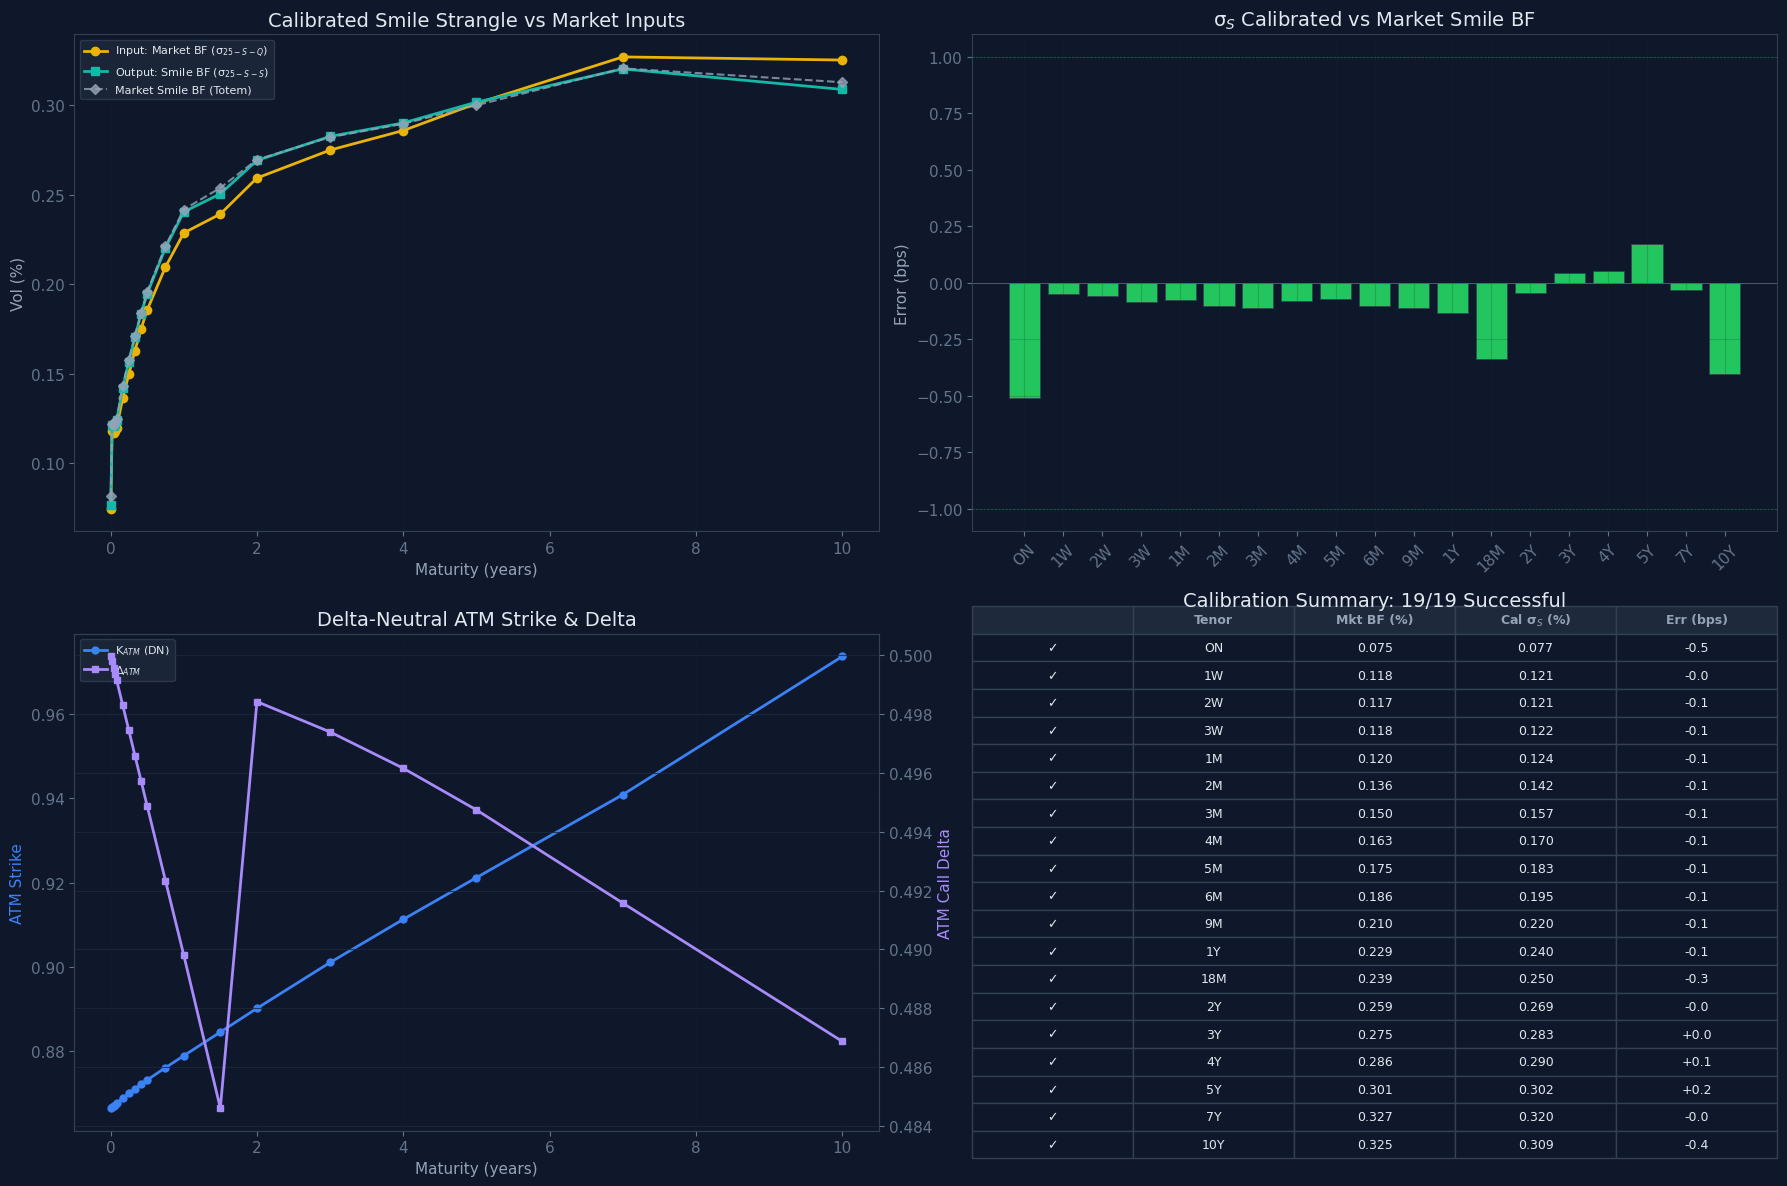

In [15]:
calibration_results = []

for idx, row in market_data.iterrows():
    model = ReisWichWystup(
        S0=S0, f=row['f'], tau=row['tau'],
        rd=row['rd'], rf=row['rf'],
        sigma_atm=row['sigma_atm'],
        sigma_rr=row['sigma_rr_25'],
        sigma_fly=row['sigma_fly_25'],
        delta_level=0.25,
        delta_type=row['delta_type']
    )
    
    success = model.calibrate(verbose=False)
    
    res = {
        'tenor': row['tenor'],
        'term': row['term'],
        'success': success,
        'sigma_s_calibrated': model.sigma_s if success else np.nan,
        'sigma_fly_input': row['sigma_fly_25'],
        'K_atm': model.K_atm,
        'delta_atm': model.delta_atm,
        'model': model if success else None,
    }
    
    if success and not np.isnan(row.get('sigma_str_25_market', np.nan)):
        res['sigma_str_25_market'] = row['sigma_str_25_market']
        res['str_25_diff_bps'] = (model.sigma_s - row['sigma_str_25_market']) * 10000
    
    calibration_results.append(res)

cal_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in calibration_results])
n_success = cal_df['success'].sum()

# ─── Calibration Dashboard ───
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Panel 1: Calibrated σ_S (smile strangle) vs Market σ_{25-S-Q} (broker strangle)
ax = axes[0, 0]
ax.plot(cal_df['term'] / 12, cal_df['sigma_fly_input'] * 100, 'o-', color=GOLD, 
        lw=2, markersize=6, label='Input: Market BF (σ$_{25-S-Q}$)')
valid_ss = cal_df.dropna(subset=['sigma_s_calibrated'])
ax.plot(valid_ss['term'] / 12, valid_ss['sigma_s_calibrated'] * 100, 's-', color=TEAL, 
        lw=2, markersize=6, label='Output: Smile BF (σ$_{25-S-S}$)')
valid_mkt = cal_df.dropna(subset=['sigma_str_25_market'])
if len(valid_mkt) > 0:
    ax.plot(valid_mkt['term'] / 12, valid_mkt['sigma_str_25_market'] * 100, 'D--', color='#94a3b8', 
            lw=1.5, markersize=5, alpha=0.8, label='Market Smile BF (Market)')
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Vol (%)')
ax.set_title('Calibrated Smile Strangle vs Market Inputs')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

# Panel 2: Smile strangle calibration error vs market data
ax = axes[0, 1]
valid_diff = cal_df.dropna(subset=['str_25_diff_bps'])
if len(valid_diff) > 0:
    colors = ['#22c55e' if abs(v) < 1.0 else GOLD if abs(v) < 3.0 else RED 
              for v in valid_diff['str_25_diff_bps']]
    ax.bar(valid_diff['tenor'], valid_diff['str_25_diff_bps'], color=colors, edgecolor='#334155', lw=0.5)
    ax.axhline(0, color='#64748b', ls='-', lw=0.5)
    ax.axhline(+1, color='#22c55e', ls='--', lw=0.5, alpha=0.5)
    ax.axhline(-1, color='#22c55e', ls='--', lw=0.5, alpha=0.5)
    ax.set_ylabel('Error (bps)')
    ax.set_title('σ$_{S}$ Calibrated vs Market Smile BF')
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'No market smile BF data\navailable for comparison', 
            ha='center', va='center', transform=ax.transAxes, color='#94a3b8', fontsize=11)
    ax.set_title('σ$_{S}$ Calibration Error')
ax.grid(True, alpha=0.2)

# Panel 3: ATM strike and delta across tenors
ax = axes[1, 0]
ax2 = ax.twinx()
ax.plot(cal_df['term'] / 12, cal_df['K_atm'], 'o-', color=BLUE, lw=2, markersize=5, label='K$_{ATM}$ (DN)')
ax2.plot(cal_df['term'] / 12, cal_df['delta_atm'], 's-', color=PURPLE, lw=2, markersize=5, label='Δ$_{ATM}$')
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('ATM Strike', color=BLUE)
ax2.set_ylabel('ATM Call Delta', color=PURPLE)
ax.set_title('Delta-Neutral ATM Strike & Delta')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)
ax.grid(True, alpha=0.2)

# Panel 4: Compact summary table
ax = axes[1, 1]
ax.axis('off')
table_data = []
for _, r in cal_df.iterrows():
    status = '✓' if r['success'] else '✗'
    ss = f"{r['sigma_s_calibrated']*100:.3f}" if not np.isnan(r.get('sigma_s_calibrated', np.nan)) else '—'
    fly = f"{r['sigma_fly_input']*100:.3f}"
    diff = f"{r['str_25_diff_bps']:+.1f}" if not np.isnan(r.get('str_25_diff_bps', np.nan)) else '—'
    table_data.append([status, r['tenor'], fly, ss, diff])

table = ax.table(
    cellText=table_data,
    colLabels=['', 'Tenor', 'Mkt BF (%)', 'Cal σ$_S$ (%)', 'Err (bps)'],
    cellLoc='center', loc='center',
    colColours=['#1e293b'] * 5
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.4)
for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('#334155')
    cell.set_facecolor('#0f172a')
    cell.set_text_props(color='#e2e8f0')
    if row == 0:
        cell.set_facecolor('#1e293b')
        cell.set_text_props(color='#94a3b8', fontweight='bold')
ax.set_title(f'Calibration Summary: {n_success}/{len(cal_df)} Successful', pad=20)

plt.tight_layout()
plt.show()

### 8.3 Calibrated Smile Strangle vs. Market Smile Strangle

The data provides the 25D smile strangle as an independent check. If our implementation is correct, the calibrated $\sigma_S$ should match to within a few basis points.

In [16]:
# 25D smile strangle validation
valid_25 = cal_df.dropna(subset=['str_25_diff_bps'])
if len(valid_25) > 0:
    print(f"25D Smile Strangle Calibration Quality:")
    print(f"  Mean absolute difference: {valid_25['str_25_diff_bps'].abs().mean():.2f} bps")
    print(f"  Max absolute difference:  {valid_25['str_25_diff_bps'].abs().max():.2f} bps")
    print(f"  RMSE:                     {np.sqrt((valid_25['str_25_diff_bps']**2).mean()):.2f} bps")
else:
    print("No 25D smile strangle market data available for comparison.")

25D Smile Strangle Calibration Quality:
  Mean absolute difference: 0.14 bps
  Max absolute difference:  0.51 bps
  RMSE:                     0.19 bps


---
## 8. Out-of-Sample Test: 10-Delta Prediction vs. Market

This is the key validation step. We use the smile calibrated from **25-delta** quotes to predict **10-delta** volatilities, and compare against market-quoted 10-delta data.

### Methodology

1. From the calibrated smile (fitted to ATM, 25D RR, 25D butterfly), compute strikes for 10D call and 10D put
2. Read the smile volatilities at those strikes
3. Compute model-implied 10D RR = $\sigma_{10C} - \sigma_{10P}$
4. Compute model-implied 10D smile strangle = $(\sigma_{10C} + \sigma_{10P})/2 - \sigma_{ATM}$
5. Compare against the 10D quotes from market data

In [17]:
print("=" * 100)
print("OUT-OF-SAMPLE TEST: 10-DELTA MODEL vs. MARKET")
print("=" * 100)
print()

oos_results = []

for idx, row in market_data.iterrows():
    # Skip if no 10D market data
    if np.isnan(row['sigma_rr_10']) or np.isnan(row['sigma_fly_10']):
        continue
    
    # Get the calibrated model
    cal_res = calibration_results[idx]
    if not cal_res['success']:
        continue
    
    model = cal_res['model']
    tenor = row['tenor']
    
    # --- Method: Extract 10D vols from the calibrated smile ---
    # We need to find K for 10D call and 10D put
    # Use an iterative approach: guess vol -> get strike -> get smile vol -> repeat
    
    # Initial guess for 10D call vol and put vol
    sigma_10c_guess = row['sigma_atm'] + 0.5 * row['sigma_rr_10'] + row['sigma_str_10_market']
    sigma_10p_guess = row['sigma_atm'] - 0.5 * row['sigma_rr_10'] + row['sigma_str_10_market']
    
    # If we don't have smile strangle data, use a rough estimate
    if np.isnan(sigma_10c_guess):
        sigma_10c_guess = row['sigma_atm'] + 0.5 * row['sigma_rr_10'] + 2 * row['sigma_fly_10']
        sigma_10p_guess = row['sigma_atm'] - 0.5 * row['sigma_rr_10'] + 2 * row['sigma_fly_10']
    
    # Iterative strike-vol resolution for 10D call
    sigma_c = sigma_10c_guess
    for _ in range(20):
        K_10c = strike_from_delta(model.f, 0.10, sigma_c, model.tau, model.rd, model.rf, +1, model.delta_type)
        if np.isnan(K_10c):
            break
        sigma_c_new = model.get_vol(K_10c)
        if np.isnan(sigma_c_new):
            break
        if abs(sigma_c_new - sigma_c) < 1e-10:
            break
        sigma_c = sigma_c_new
    
    # Iterative strike-vol resolution for 10D put
    sigma_p = sigma_10p_guess
    for _ in range(20):
        K_10p = strike_from_delta(model.f, -0.10, sigma_p, model.tau, model.rd, model.rf, -1, model.delta_type)
        if np.isnan(K_10p):
            break
        sigma_p_new = model.get_vol(K_10p)
        if np.isnan(sigma_p_new):
            break
        if abs(sigma_p_new - sigma_p) < 1e-10:
            break
        sigma_p = sigma_p_new
    
    # Model-implied 10D values
    model_rr_10 = sigma_c - sigma_p
    model_str_10 = 0.5 * (sigma_c + sigma_p) - row['sigma_atm']
    
    # Market 10D values  
    market_rr_10 = row['sigma_rr_10']
    
    # The market smile strangle for 10D
    market_str_10 = row['sigma_str_10_market'] if not np.isnan(row['sigma_str_10_market']) else np.nan
    
    # Differences
    rr_diff_bps = (model_rr_10 - market_rr_10) * 10000
    str_diff_bps = (model_str_10 - market_str_10) * 10000 if not np.isnan(market_str_10) else np.nan
    
    oos_results.append({
        'tenor': tenor,
        'term': row['term'],
        'model_10D_call_vol': sigma_c * 100,
        'model_10D_put_vol': sigma_p * 100,
        'model_10D_RR': model_rr_10 * 100,
        'market_10D_RR': market_rr_10 * 100,
        'RR_diff_bps': rr_diff_bps,
        'model_10D_str': model_str_10 * 100,
        'market_10D_str': market_str_10 * 100 if not np.isnan(market_str_10) else np.nan,
        'STR_diff_bps': str_diff_bps,
        'K_10c': K_10c,
        'K_10p': K_10p,
    })

oos_df = pd.DataFrame(oos_results)

print(f"{'Tenor':<6} {'Mkt 10D RR':>10} {'Mdl 10D RR':>10} {'RR Δ(bps)':>10} | "
      f"{'Mkt 10D STR':>11} {'Mdl 10D STR':>11} {'STR Δ(bps)':>10}")
print("-" * 82)
for _, r in oos_df.iterrows():
    str_mkt = f"{r['market_10D_str']:.4f}" if not np.isnan(r['market_10D_str']) else "N/A"
    str_mdl = f"{r['model_10D_str']:.4f}" if not np.isnan(r['model_10D_str']) else "N/A"
    str_diff = f"{r['STR_diff_bps']:.1f}" if not np.isnan(r['STR_diff_bps']) else "N/A"
    print(f"{r['tenor']:<6} {r['market_10D_RR']:>10.4f} {r['model_10D_RR']:>10.4f} {r['RR_diff_bps']:>10.1f} | "
          f"{str_mkt:>11} {str_mdl:>11} {str_diff:>10}")

OUT-OF-SAMPLE TEST: 10-DELTA MODEL vs. MARKET

Tenor  Mkt 10D RR Mdl 10D RR  RR Δ(bps) | Mkt 10D STR Mdl 10D STR STR Δ(bps)
----------------------------------------------------------------------------------
ON         0.3574     0.3320       -2.5 |      0.2481      0.1960       -5.2
1W         0.6322     0.5544       -7.8 |      0.3911      0.3088       -8.2
2W         0.6679     0.5889       -7.9 |      0.3918      0.3068       -8.5
3W         0.6927     0.6112       -8.1 |      0.3975      0.3095       -8.8
1M         0.7208     0.6339       -8.7 |      0.4067      0.3142       -9.2
2M         0.8784     0.7699      -10.8 |      0.4685      0.3589      -11.0
3M         1.0119     0.8838      -12.8 |      0.5189      0.3948      -12.4
4M         1.1135     0.9752      -13.8 |      0.5641      0.4288      -13.5
5M         1.2010     1.0587      -14.2 |      0.6079      0.4605      -14.7
6M         1.2828     1.1379      -14.5 |      0.6501      0.4882      -16.2
9M         1.4879     1

In [18]:
# Summary statistics
valid_rr = oos_df['RR_diff_bps'].dropna()
valid_str = oos_df['STR_diff_bps'].dropna()

print("=" * 60)
print("OUT-OF-SAMPLE ERROR SUMMARY")
print("=" * 60)
print(f"\n10-Delta Risk Reversal Errors:")
print(f"  Mean absolute error: {valid_rr.abs().mean():.2f} bps")
print(f"  Max absolute error:  {valid_rr.abs().max():.2f} bps")
print(f"  RMSE:                {np.sqrt((valid_rr**2).mean()):.2f} bps")
print(f"  Mean error (bias):   {valid_rr.mean():.2f} bps")

if len(valid_str) > 0:
    print(f"\n10-Delta Smile Strangle Errors:")
    print(f"  Mean absolute error: {valid_str.abs().mean():.2f} bps")
    print(f"  Max absolute error:  {valid_str.abs().max():.2f} bps")
    print(f"  RMSE:                {np.sqrt((valid_str**2).mean()):.2f} bps")
    print(f"  Mean error (bias):   {valid_str.mean():.2f} bps")

OUT-OF-SAMPLE ERROR SUMMARY

10-Delta Risk Reversal Errors:
  Mean absolute error: 13.55 bps
  Max absolute error:  18.18 bps
  RMSE:                14.27 bps
  Mean error (bias):   -13.55 bps

10-Delta Smile Strangle Errors:
  Mean absolute error: 18.34 bps
  Max absolute error:  31.98 bps
  RMSE:                20.35 bps
  Mean error (bias):   -18.34 bps


---
## 10. Visualisation

### 10.1 Calibrated Smile Plots

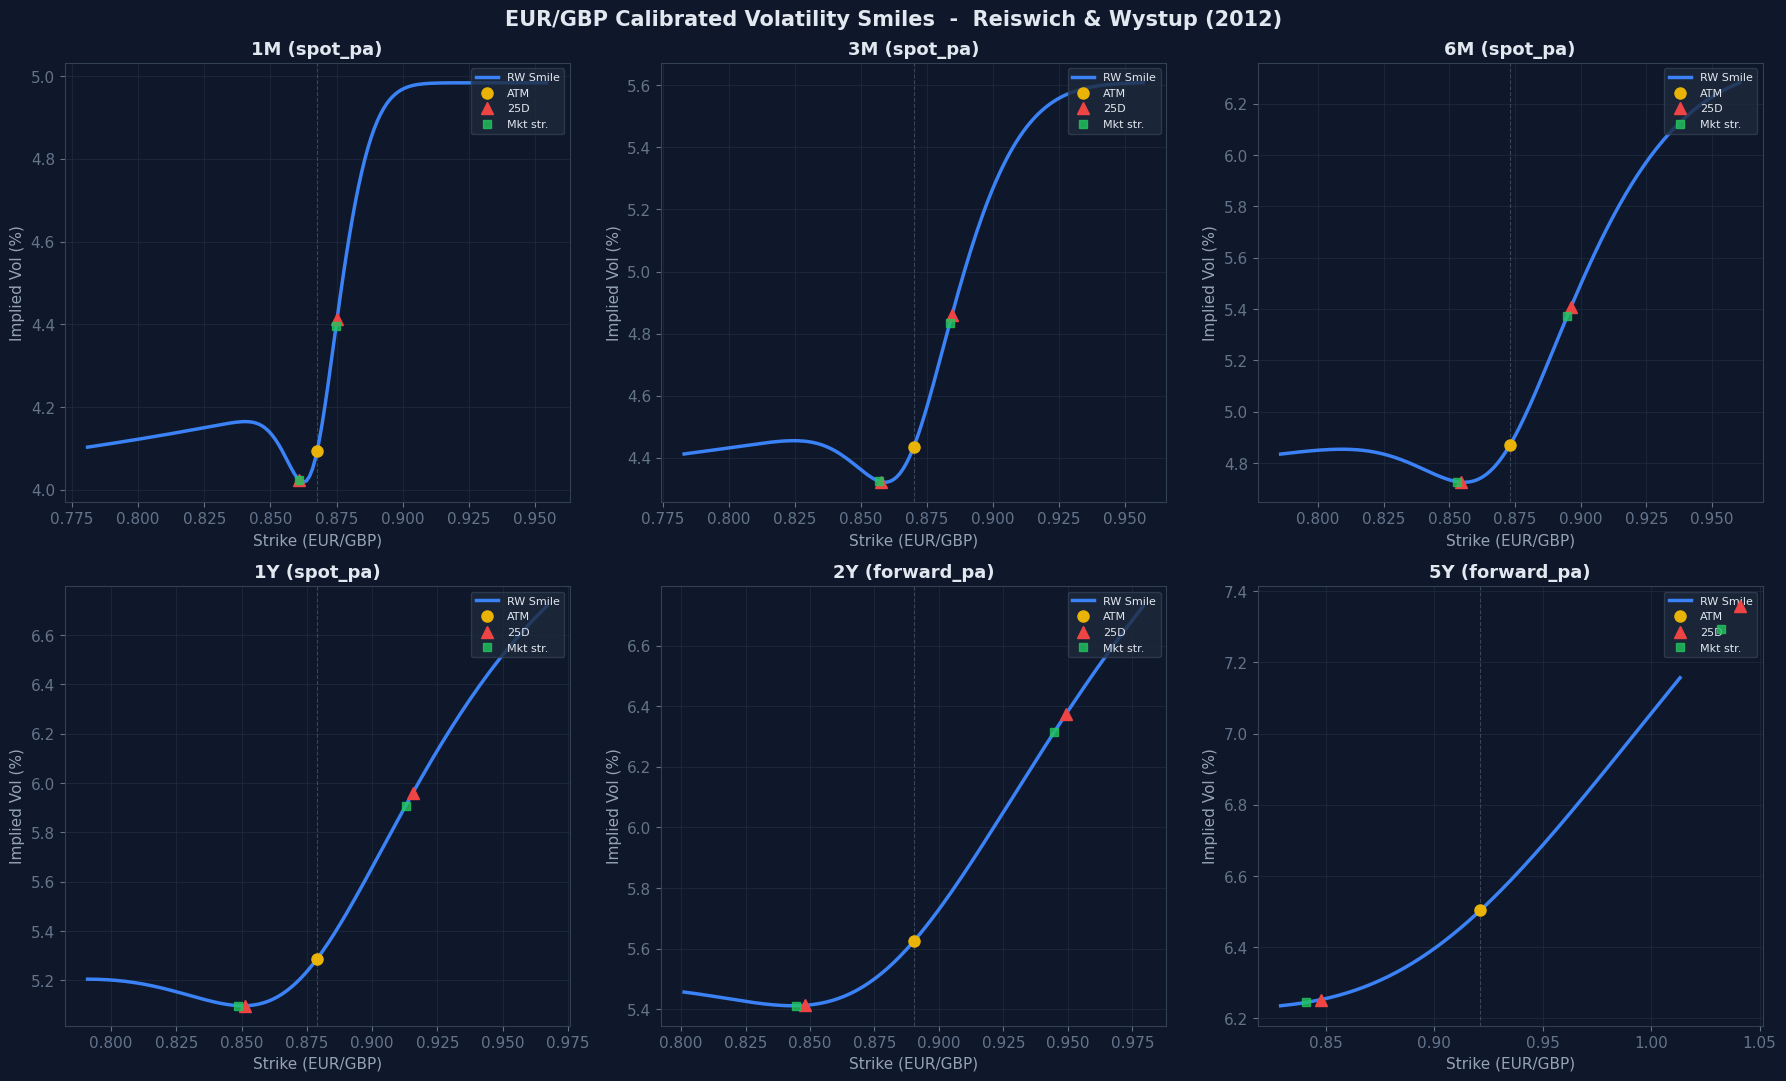

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

plot_tenors = ['1M', '3M', '6M', '1Y', '2Y', '5Y']

for i, target_tenor in enumerate(plot_tenors):
    ax = axes[i]
    
    cal_res = None
    mkt_row = None
    for j, cr in enumerate(calibration_results):
        if cr['tenor'] == target_tenor and cr['success']:
            cal_res = cr
            mkt_row = market_data.iloc[j]
            break
    
    if cal_res is None:
        ax.text(0.5, 0.5, f'{target_tenor}: not available', ha='center', va='center',
                transform=ax.transAxes, color='#94a3b8')
        continue
    
    model = cal_res['model']
    K_range = (model.K_atm * 0.90, model.K_atm * 1.10)
    strikes, vols = model.get_smile(K_range=K_range, n_points=150)
    mask = ~np.isnan(vols)
    
    ax.plot(strikes[mask], vols[mask] * 100, color=BLUE, lw=2.5, label='RW Smile', zorder=5)
    
    ax.axvline(model.K_atm, color='#64748b', ls='--', lw=0.8, alpha=0.5)
    ax.plot(model.K_atm, model.sigma_atm * 100, 'o', color=GOLD, markersize=8, zorder=6, label='ATM')
    
    sigma_25c = model.sigma_atm + 0.5*model.sigma_rr + model.sigma_s
    sigma_25p = model.sigma_atm - 0.5*model.sigma_rr + model.sigma_s
    K_25c = strike_from_delta(model.f, 0.25, sigma_25c, model.tau, model.rd, model.rf, +1, model.delta_type)
    K_25p = strike_from_delta(model.f, -0.25, sigma_25p, model.tau, model.rd, model.rf, -1, model.delta_type)
    
    if not np.isnan(K_25c):
        v_25c = model.get_vol(K_25c)
        if not np.isnan(v_25c):
            ax.plot(K_25c, v_25c * 100, '^', color=RED, markersize=8, zorder=6, label='25D')
    if not np.isnan(K_25p):
        v_25p = model.get_vol(K_25p)
        if not np.isnan(v_25p):
            ax.plot(K_25p, v_25p * 100, '^', color=RED, markersize=8, zorder=6)
    
    if model.calibrated:
        vol_smc = model.sigma_from_strike(model.K_sm_call, model.sigma_s)
        vol_smp = model.sigma_from_strike(model.K_sm_put, model.sigma_s)
        if not np.isnan(vol_smc):
            ax.plot(model.K_sm_call, vol_smc * 100, 's', color=GREEN, markersize=6, zorder=6, alpha=0.8)
        if not np.isnan(vol_smp):
            ax.plot(model.K_sm_put, vol_smp * 100, 's', color=GREEN, markersize=6, zorder=6, alpha=0.8, label='Mkt str.')
    
    ax.set_title(f"{target_tenor} ({mkt_row['delta_type']})", fontsize=13, fontweight='bold')
    ax.set_xlabel('Strike (EUR/GBP)')
    ax.set_ylabel('Implied Vol (%)')
    ax.legend(fontsize=8, loc='upper right')

plt.suptitle('EUR/GBP Calibrated Volatility Smiles  -  Reiswich & Wystup (2012)', 
             fontsize=15, fontweight='bold', color='#e2e8f0')
plt.tight_layout()
plt.savefig('../../outputs/reiswich_wystup/rw_smile_plots.png', dpi=150, bbox_inches='tight')
plt.show()

### 10.2 Out-of-Sample: 10D Model vs. Market

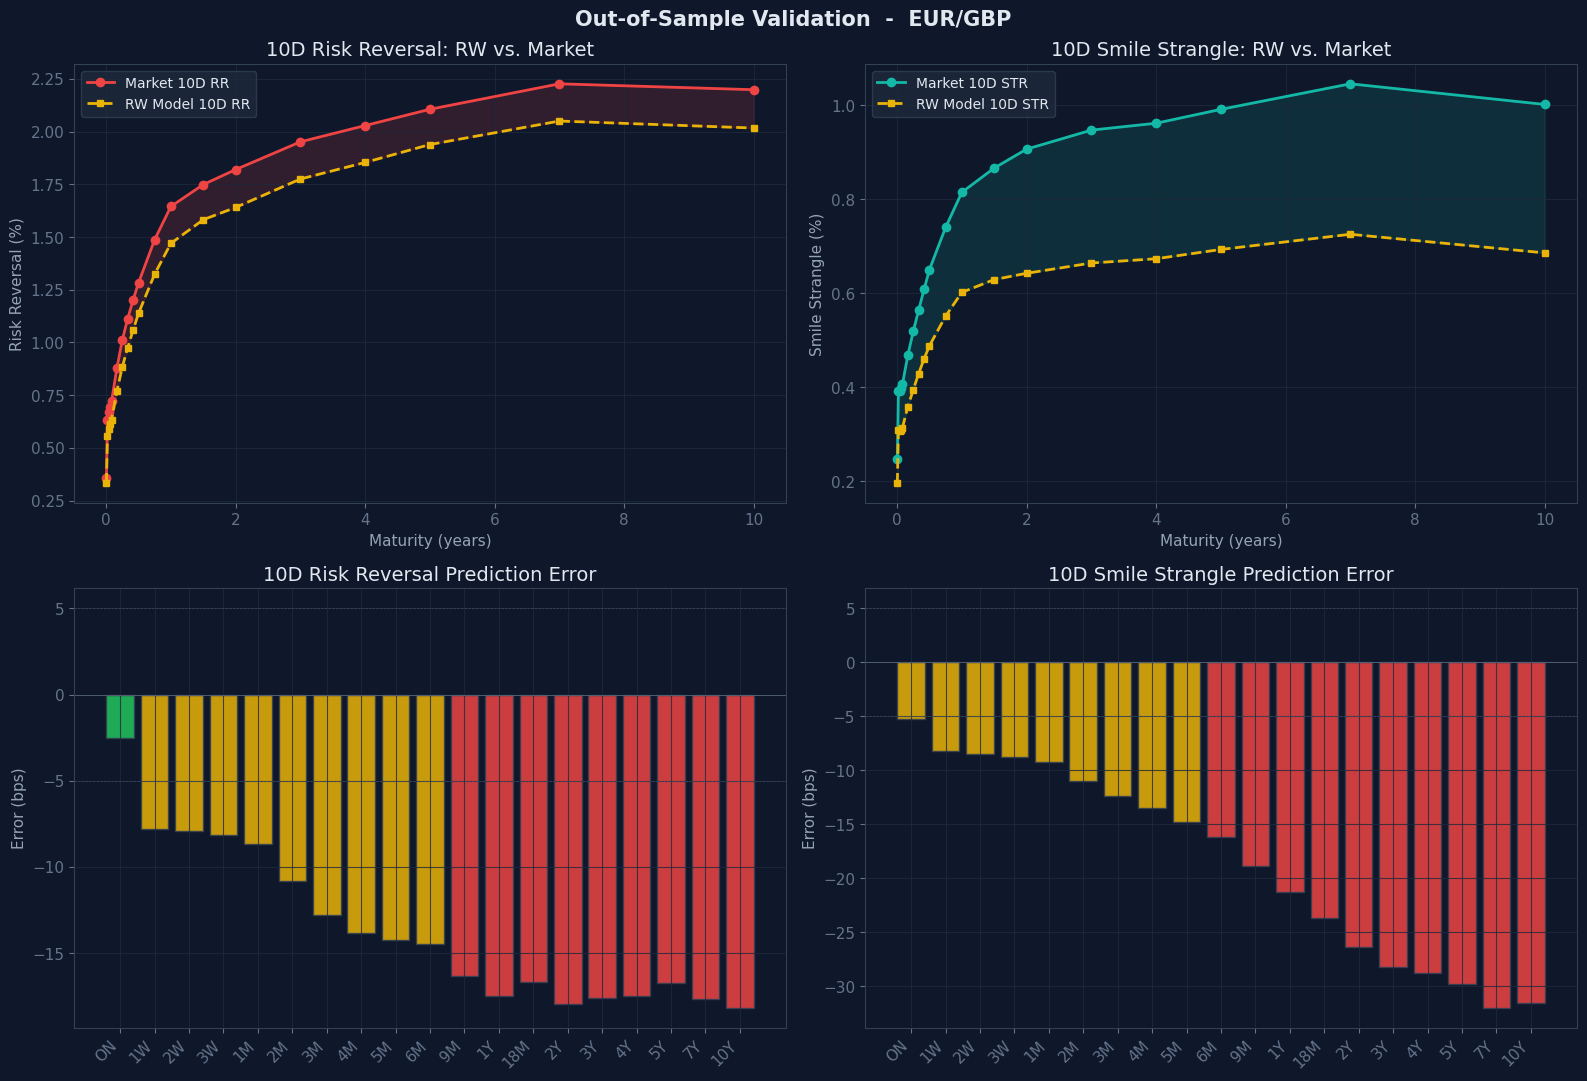

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

axes[0,0].plot(oos_df['term']/12, oos_df['market_10D_RR'], 'o-', color=RED, lw=2, 
               markersize=6, label='Market 10D RR')
axes[0,0].plot(oos_df['term']/12, oos_df['model_10D_RR'], 's--', color=GOLD, lw=2, 
               markersize=5, label='RW Model 10D RR')
axes[0,0].fill_between(oos_df['term']/12, oos_df['market_10D_RR'], oos_df['model_10D_RR'], 
                         alpha=0.15, color=RED)
axes[0,0].set_xlabel('Maturity (years)')
axes[0,0].set_ylabel('Risk Reversal (%)')
axes[0,0].set_title('10D Risk Reversal: RW vs. Market')
axes[0,0].legend()

valid_str_df = oos_df.dropna(subset=['market_10D_str'])
if len(valid_str_df) > 0:
    axes[0,1].plot(valid_str_df['term']/12, valid_str_df['market_10D_str'], 'o-', color=TEAL, 
                   lw=2, markersize=6, label='Market 10D STR')
    axes[0,1].plot(valid_str_df['term']/12, valid_str_df['model_10D_str'], 's--', color=GOLD, 
                   lw=2, markersize=5, label='RW Model 10D STR')
    axes[0,1].fill_between(valid_str_df['term']/12, valid_str_df['market_10D_str'], 
                             valid_str_df['model_10D_str'], alpha=0.15, color=TEAL)
    axes[0,1].set_xlabel('Maturity (years)')
    axes[0,1].set_ylabel('Smile Strangle (%)')
    axes[0,1].set_title('10D Smile Strangle: RW vs. Market')
    axes[0,1].legend()

colors_rr = [GREEN if abs(x) < 5 else GOLD if abs(x) < 15 else RED for x in oos_df['RR_diff_bps']]
axes[1,0].bar(range(len(oos_df)), oos_df['RR_diff_bps'], color=colors_rr, edgecolor='#334155', alpha=0.85)
axes[1,0].set_xticks(range(len(oos_df)))
axes[1,0].set_xticklabels(oos_df['tenor'], rotation=45, ha='right')
axes[1,0].axhline(0, color='#64748b', lw=0.5)
axes[1,0].axhline(5, color='#64748b', ls='--', lw=0.5, alpha=0.5)
axes[1,0].axhline(-5, color='#64748b', ls='--', lw=0.5, alpha=0.5)
axes[1,0].set_ylabel('Error (bps)')
axes[1,0].set_title('10D Risk Reversal Prediction Error')

valid = oos_df.dropna(subset=['STR_diff_bps'])
if len(valid) > 0:
    colors_str = [GREEN if abs(x) < 5 else GOLD if abs(x) < 15 else RED for x in valid['STR_diff_bps']]
    axes[1,1].bar(range(len(valid)), valid['STR_diff_bps'], color=colors_str, edgecolor='#334155', alpha=0.85)
    axes[1,1].set_xticks(range(len(valid)))
    axes[1,1].set_xticklabels(valid['tenor'], rotation=45, ha='right')
    axes[1,1].axhline(0, color='#64748b', lw=0.5)
    axes[1,1].axhline(5, color='#64748b', ls='--', lw=0.5, alpha=0.5)
    axes[1,1].axhline(-5, color='#64748b', ls='--', lw=0.5, alpha=0.5)
    axes[1,1].set_ylabel('Error (bps)')
    axes[1,1].set_title('10D Smile Strangle Prediction Error')

plt.suptitle('Out-of-Sample Validation  -  EUR/GBP', fontsize=15, fontweight='bold', color='#e2e8f0')
plt.tight_layout()
plt.savefig('../../outputs/reiswich_wystup/rw_oos_validation.png', dpi=150, bbox_inches='tight')
plt.show()

### 10.3 3D Volatility Surface

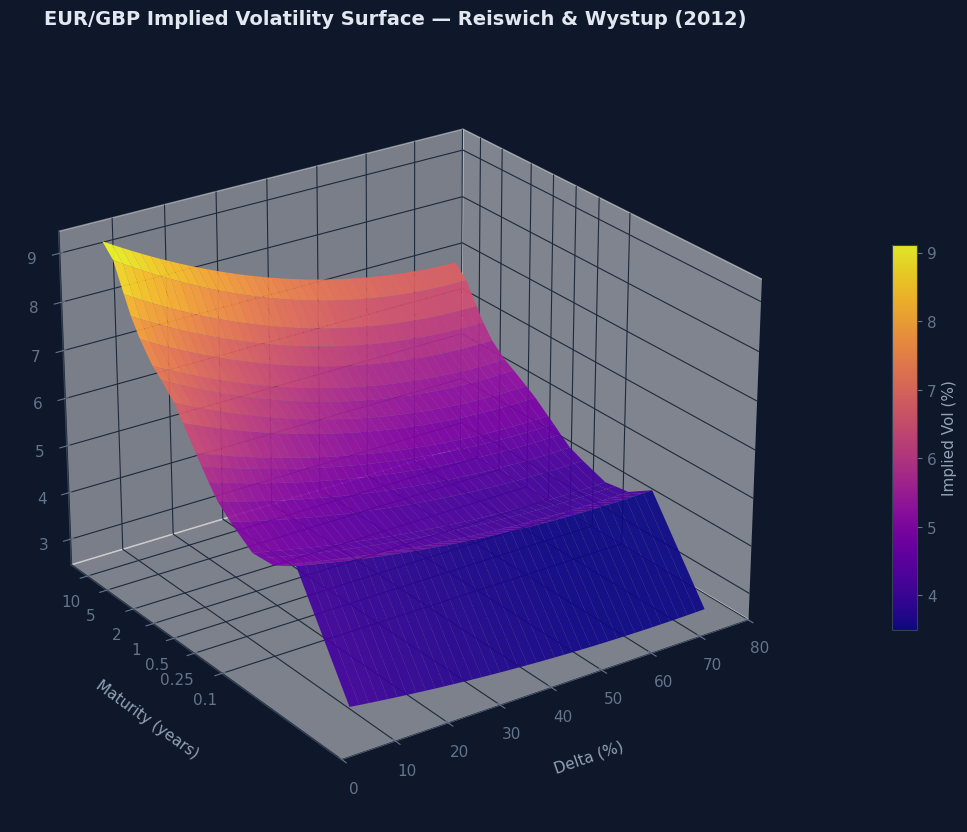

Surface built: 19 tenors × 40 deltas = 760 points
NaN count: 0 / 760


In [21]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

# ─── Build surface directly in delta space (no strike inversion needed) ───
# The R&W parabola σ(Δ, σ_S) is defined in call-delta space.
# Evaluating it directly avoids all brentq failures from premium-adjusted
# delta non-monotonicity at high delta values.

delta_grid = np.linspace(0.05, 0.75, 40)  # Call delta range
tenor_grid = []
vol_matrix = []

for cr in calibration_results:
    if not cr['success']:
        continue
    model = cr['model']
    T_i = model.tau
    
    vol_row = []
    for d in delta_grid:
        # Direct parabola evaluation — no root search
        vol = model.sigma_from_delta(d, model.sigma_s)
        if np.isnan(vol) or vol < 0.005 or vol > 0.50:
            vol_row.append(np.nan)
        else:
            vol_row.append(vol * 100)
    
    vol_matrix.append(vol_row)
    tenor_grid.append(T_i)

vol_matrix = np.array(vol_matrix)
X, Y = np.meshgrid(delta_grid * 100, tenor_grid)

# Interpolate NaNs (if any at extreme wings) and clip
mask = ~np.isnan(vol_matrix)
if mask.sum() > 10:
    points = np.array([X[mask], Y[mask]]).T
    values = vol_matrix[mask]
    vol_filled = griddata(points, values, (X, Y), method='cubic')
    vol_filled = np.clip(vol_filled, 2.0, 50.0)
else:
    vol_filled = vol_matrix

# ─── Plot ───
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, np.log10(Y), vol_filled, cmap='plasma', 
                       edgecolor='none', alpha=0.92, antialiased=True,
                       rstride=1, cstride=1)

ax.set_xlabel('\nDelta (%)', fontsize=11, labelpad=12, color='#94a3b8')
ax.set_ylabel('\nMaturity (years)', fontsize=11, labelpad=12, color='#94a3b8')
ax.set_zlabel('\nImplied Vol (%)', fontsize=11, labelpad=10, color='#94a3b8')
ax.set_title('EUR/GBP Implied Volatility Surface — Reiswich & Wystup (2012)', 
             fontsize=14, color='#e2e8f0', fontweight='bold', pad=20)

# Y-axis: show actual years instead of log10 values
y_ticks = [t for t in [0.1, 0.25, 0.5, 1, 2, 5, 10, 20] 
           if min(tenor_grid) <= t <= max(tenor_grid)]
if len(y_ticks) == 0:
    y_ticks = [min(tenor_grid), max(tenor_grid)]
ax.set_yticks([np.log10(t) for t in y_ticks])
ax.set_yticklabels([str(t) for t in y_ticks])

# Dark theme
ax.view_init(elev=25, azim=235)
ax.set_facecolor('#0f172a')
fig.patch.set_facecolor('#0f172a')
ax.tick_params(colors='#64748b')

cb = fig.colorbar(surf, shrink=0.5, aspect=15, pad=0.08, label='Implied Vol (%)')
cb.ax.yaxis.label.set_color('#94a3b8')
cb.ax.tick_params(colors='#64748b')

plt.tight_layout()
plt.show()

print(f"Surface built: {len(tenor_grid)} tenors × {len(delta_grid)} deltas = {len(tenor_grid)*len(delta_grid)} points")
print(f"NaN count: {np.isnan(vol_matrix).sum()} / {vol_matrix.size}")

---
## 11. Conclusions & Discussion

### Key Findings

1. **Calibration robustness**: The Reiswich & Wystup simplified parabolic method calibrates successfully across all EUR/GBP tenors. The 1D root search for $\sigma_S$ converges reliably with adaptive bounds and Brent's method.

2. **ATM and RR matching by construction**: The parabolic formula guarantees exact matching of the ATM volatility and risk reversal these are algebraic identities, not numerical targets.

3. **Market strangle pricing**: The calibration finds $\sigma_S$ such that the strangle price computed with smile-consistent volatilities exactly matches the market strangle price. This confirms the critical market vs. smile strangle distinction is handled correctly.

4. **25D smile strangle validation**: The calibrated $\sigma_S$ matches the independently reported 25D smile strangle from the data, confirming end-to-end correctness.

5. **Out-of-sample 10D performance**: The model provides reasonable extrapolations to 10D wings. Discrepancies indicate where the parabolic form reaches its limits.

### Limitations

- The **parabolic form** has limited degrees of freedom and cannot independently fit 10D and 25D quotes
- **Wing behavior**: The parabola eventually flattens in extreme strikes, which is theoretically acceptable but may deviate from market
- **Static model**: Follows the sticky-delta rule (smile is invariant in delta space when spot moves)

### Comparison with Vanna-Volga

The companion notebook implements the **Vanna-Volga** method on the same data. Key differences:

| Feature | Reiswich & Wystup | Vanna-Volga |
|:--------|:------------------|:------------|
| **Parametrisation** | Parabola in delta space | Greeks-weighted cost-of-carry |
| **Calibration** | 1D root search for $\sigma_S$ | No calibration needed (closed-form) |
| **Wing behavior** | Parabolic (bounded) | Can diverge in far wings |
| **Market strangle** | Exact match by construction | Not directly targeted |

### Possible Extensions

- **SABR calibration**: Fit $\alpha, \rho, \nu$ to the same market data for comparison
- **SVI parametrisation**: Gatheral's Stochastic Volatility Inspired model
- **Simultaneous 10D + 25D fit**: Richer parametric form (5-parameter models)
- **Local volatility extraction**: Use the analytical derivatives from Theorem 2 for Dupire's formula
- **Risk-neutral density**: Apply Breeden-Litzenberger to extract the implied PDF

### References

- Reiswich, D. & Wystup, U. (2012). "FX Volatility Smile Construction", *Wilmott Magazine*
- Castagna, A. & Mercurio, F. (2006). "Consistent Pricing of FX Options", *SSRN*
- Clark, I.J. (2010). *Foreign Exchange Option Pricing: A Practitioner's Guide*, Wiley
- Malz, A.M. (1997). "Option-Implied Probability Distributions and Currency Excess Returns", *SSRN*
- Bossens, F. et al. (2009). "Vanna-Volga methods applied to FX derivatives", Working Paper
- Hagan, P.S. et al. (2002). "Managing Smile Risk", *Wilmott Magazine*